In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

from scipy.stats import chi2_contingency, randint, uniform
from phik import resources

from joblib import dump, load

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, classification_report, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('heart_train.csv')
df_train = df_train.drop('Unnamed: 0', axis=1)
df_train.head()

Age  Cholesterol  Heart rate  Diabetes  Family History  Smoking  \
0  0.359551     0.732143    0.074244       1.0             1.0      1.0   
1  0.202247     0.325000    0.047663       1.0             1.0      0.0   
2  0.606742     0.860714    0.055912       1.0             0.0      1.0   
3  0.730337     0.007143    0.053162       0.0             0.0      1.0   
4  0.775281     0.757143    0.021998       0.0             0.0      1.0   

   Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  ...  \
0      1.0                  1.0                 0.535505     1  ...   
1      0.0                  1.0                 0.068690     2  ...   
2      1.0                  1.0                 0.944001     2  ...   
3      0.0                  1.0                 0.697023     0  ...   
4      0.0                  1.0                 0.412878     1  ...   

   Physical Activity Days Per Week  Sleep Hours Per Day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   
3                              0.0             0.333333   
4                              5.0             1.000000   

   Heart Attack Risk (Binary)  Blood sugar     CK-MB  Troponin  Gender  \
0                         0.0     0.227018  0.048229  0.036512    Male   
1                         0.0     0.150198  0.017616  0.000194  Female   
2                         0.0     0.227018  0.048229  0.036512  Female   
3                         1.0     0.227018  0.048229  0.036512  Female   
4                         1.0     0.227018  0.048229  0.036512    Male   

   Systolic blood pressure  Diastolic blood pressure    id  
0                 0.212903                  0.709302  2664  
1                 0.412903                  0.569767  9287  
2                 0.238710                  0.220930  5379  
3                 0.348387                  0.267442  8222  
4                 0.619355                  0.441860  4047  

[5 rows x 27 columns]

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level        

In [4]:
df_test = pd.read_csv('heart_test.csv')
df_test = df_test.drop('Unnamed: 0', axis=1)
df_test.head()

Age  Cholesterol  Heart rate  Diabetes  Family History  Smoking  \
0  0.494382     0.264286    0.062328       0.0             1.0      1.0   
1  0.224719     0.953571    0.082493       1.0             0.0      0.0   
2  0.629213     0.092857    0.064161       0.0             1.0      1.0   
3  0.460674     0.567857    0.055912       1.0             1.0      1.0   
4  0.719101     0.485714    0.022915       1.0             0.0      1.0   

   Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  ...  \
0      1.0                  1.0                 0.361618     2  ...   
1      1.0                  0.0                 0.996483     2  ...   
2      1.0                  0.0                 0.995561     0  ...   
3      1.0                  1.0                 0.437277     0  ...   
4      0.0                  1.0                 0.514920     0  ...   

   Triglycerides  Physical Activity Days Per Week  Sleep Hours Per Day  \
0       0.306494                              1.0             0.333333   
1       0.087013                              0.0             0.166667   
2       0.205195                              7.0             1.000000   
3       0.163636                              0.0             0.666667   
4       0.580519                              5.0             0.000000   

   Blood sugar     CK-MB  Troponin  Gender  Systolic blood pressure  \
0     0.227018  0.048229  0.036512    Male                 0.283871   
1     0.227018  0.048229  0.036512  Female                 0.703226   
2     0.102767  0.002666  0.088455    Male                 0.458065   
3     0.203557  0.056390  0.271774  Female                 0.741935   
4     0.227018  0.048229  0.036512    Male                 0.412903   

   Diastolic blood pressure    id  
0                  0.372093  7746  
1                  0.441860  4202  
2                  0.779070  6632  
3                  0.255814  4639  
4                  0.395349  4825  

[5 rows x 26 columns]

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              966 non-null    float64
 1   Cholesterol                      966 non-null    float64
 2   Heart rate                       966 non-null    float64
 3   Diabetes                         935 non-null    float64
 4   Family History                   935 non-null    float64
 5   Smoking                          935 non-null    float64
 6   Obesity                          935 non-null    float64
 7   Alcohol Consumption              935 non-null    float64
 8   Exercise Hours Per Week          966 non-null    float64
 9   Diet                             966 non-null    int64  
 10  Previous Heart Problems          935 non-null    float64
 11  Medication Use                   935 non-null    float64
 12  Stress Level          

–î–∞–Ω–Ω—ã–µ —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω—ã

# –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö

In [6]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –ø—Ä–æ–≤–µ—Ä–∫–∏ –¥–∞–Ω–Ω—ã—Ö
def preprocess(df):
    print('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤:')
    print(df.isna().sum())
    print('\n–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —è–≤–Ω—ã—Ö –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: ', df.duplicated().sum())
    
    # –°–æ–∑–¥–∞–Ω–∏–µ –∫–æ–ø–∏–∏ –Ω–∞–±–æ—Ä–∞ –¥–∞–Ω–Ω—ã—Ö 
    df_copy = df.copy()

    # –ü—Ä–∏–≤–µ–¥–µ–Ω–∏–µ –∫ –Ω–∏–∂–Ω–µ–º—É —Ä–µ–≥–∏—Å—Ç—Ä—É –∏ —É–¥–∞–ª–µ–Ω–∏–µ –ø—Ä–æ–±–µ–ª–æ–≤ –¥–ª—è –ø—Ä–æ–≤–µ—Ä–∫–∏ –Ω–µ—è–≤–Ω—ã—Ö –¥—É–±–ª–∏–∫–∞—Ç–æ–≤
    for col in df_copy.select_dtypes(include=['object', 'category']).columns:
        df_copy[col] = df_copy[col].astype(str).str.lower().str.replace(' ', '', regex=False)

    print(f'–ö–æ–ª–∏—á–µ—Å—Ç–æ–≤ –Ω–µ—è–≤–Ω—ã—Ö –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: {df_copy.duplicated().sum()}\n')

    # –£–¥–∞–ª—è–µ–º –∫–æ–ø–∏—é –¥–ª—è —ç–∫–æ–Ω–æ–º–∏–∏ –ø–∞–º—è—Ç–∏
    del df_copy

    # –ü—Ä–æ–≤–µ—Ä–∫–∞ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –¥–ª—è –∫–æ—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π
    for col in df.select_dtypes(include=['object', 'category']).columns:
        print(f'–°—Ç–æ–ª–±–µ—Ü: {col} \n–∑–Ω–∞—á–µ–Ω–∏—è —Å—Ç–æ–ª–±—Ü–∞: {df[col].unique()}\n')

In [7]:
preprocess(df_train)
print('--------------------------')
preprocess(df_test)

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤:
Age                                  0
Cholesterol                          0
Heart rate                           0
Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Exercise Hours Per Week              0
Diet                                 0
Previous Heart Problems            243
Medication Use                     243
Stress Level                       243
Sedentary Hours Per Day              0
Income                               0
BMI                                  0
Triglycerides                        0
Physical Activity Days Per Week    243
Sleep Hours Per Day                  0
Heart Attack Risk (Binary)           0
Blood sugar                          0
CK-MB                                0
Troponin                             0
Gender                               0
Systolic blood pressure

–°—Ç–æ–ª–±–µ—Ü: Gender 
–∑–Ω–∞—á–µ–Ω–∏—è —Å—Ç–æ–ª–±—Ü–∞: ['Male' 'Female' '1.0' '0.0']

--------------------------
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤:
Age                                 0
Cholesterol                         0
Heart rate                          0
Diabetes                           31
Family History                     31
Smoking                            31
Obesity                            31
Alcohol Consumption                31
Exercise Hours Per Week             0
Diet                                0
Previous Heart Problems            31
Medication Use                     31
Stress Level                       31
Sedentary Hours Per Day             0
Income                              0
BMI                                 0
Triglycerides                       0
Physical Activity Days Per Week    31
Sleep Hours Per Day                 0
Blood sugar                         0
CK-MB                               0
Troponin                            0
Gender  

In [8]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [9]:
preprocess(df_train)
print('--------------------------')
preprocess(df_test)

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤:
Age                                0
Cholesterol                        0
Heart rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Alcohol Consumption                0
Exercise Hours Per Week            0
Diet                               0
Previous Heart Problems            0
Medication Use                     0
Stress Level                       0
Sedentary Hours Per Day            0
Income                             0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
Sleep Hours Per Day                0
Heart Attack Risk (Binary)         0
Blood sugar                        0
CK-MB                              0
Troponin                           0
Gender                             0
Systolic blood pressure            0
Diastolic blood pressure          

–ö–æ–ª–∏—á–µ—Å—Ç–æ–≤ –Ω–µ—è–≤–Ω—ã—Ö –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: 0

–°—Ç–æ–ª–±–µ—Ü: Gender 
–∑–Ω–∞—á–µ–Ω–∏—è —Å—Ç–æ–ª–±—Ü–∞: ['Male' 'Female']

--------------------------
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤:
Age                                0
Cholesterol                        0
Heart rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Alcohol Consumption                0
Exercise Hours Per Week            0
Diet                               0
Previous Heart Problems            0
Medication Use                     0
Stress Level                       0
Sedentary Hours Per Day            0
Income                             0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
Sleep Hours Per Day                0
Blood sugar                        0
CK-MB                              0
Troponin          

In [10]:
df_train.describe().T

count         mean          std       min  \
Age                              8442.0     0.449008     0.232809  0.044944   
Cholesterol                      8442.0     0.501108     0.288785  0.000000   
Heart rate                       8442.0     0.050194     0.018442  0.018332   
Diabetes                         8442.0     0.652097     0.476333  0.000000   
Family History                   8442.0     0.489576     0.499921  0.000000   
Smoking                          8442.0     0.902867     0.296157  0.000000   
Obesity                          8442.0     0.498342     0.500027  0.000000   
Alcohol Consumption              8442.0     0.601990     0.489517  0.000000   
Exercise Hours Per Week          8442.0     0.503415     0.288881  0.000000   
Diet                             8442.0     1.001540     0.812981  0.000000   
Previous Heart Problems          8442.0     0.495380     0.500008  0.000000   
Medication Use                   8442.0     0.501185     0.500028  0.000000   
Stress Level                     8442.0     5.493367     2.867862  1.000000   
Sedentary Hours Per Day          8442.0     0.499142     0.289418  0.000000   
Income                           8442.0     0.496089     0.288767  0.000000   
BMI                              8442.0     0.496831     0.286599  0.000000   
Triglycerides                    8442.0     0.505539     0.290412  0.000000   
Physical Activity Days Per Week  8442.0     3.508292     2.281772  0.000000   
Sleep Hours Per Day              8442.0     0.503712     0.332749  0.000000   
Heart Attack Risk (Binary)       8442.0     0.356906     0.479115  0.000000   
Blood sugar                      8442.0     0.227998     0.074623  0.000000   
CK-MB                            8442.0     0.047745     0.070399  0.000000   
Troponin                         8442.0     0.036867     0.059284  0.000000   
Systolic blood pressure          8442.0     0.451955     0.170187  0.161290   
Diastolic blood pressure         8442.0     0.501672     0.170302  0.209302   
id                               8442.0  4696.392087  2704.773301  1.000000   

                                         25%          50%          75%  \
Age                                 0.247191     0.460674     0.640449   
Cholesterol                         0.260714     0.496429     0.750000   
Heart rate                          0.034830     0.050412     0.065995   
Diabetes                            0.000000     1.000000     1.000000   
Family History                      0.000000     0.000000     1.000000   
Smoking                             1.000000     1.000000     1.000000   
Obesity                             0.000000     0.000000     1.000000   
Alcohol Consumption                 0.000000     1.000000     1.000000   
Exercise Hours Per Week             0.253359     0.508244     0.754901   
Diet                                0.000000     1.000000     2.000000   
Previous Heart Problems             0.000000     0.000000     1.000000   
Medication Use                      0.000000     1.000000     1.000000   
Stress Level                        3.000000     5.000000     8.000000   
Sedentary Hours Per Day             0.247650     0.492734     0.751047   
Income                              0.244591     0.496052     0.747603   
BMI                                 0.247935     0.490801     0.744399   
Triglycerides                       0.257143     0.507792     0.758442   
Physical Activity Days Per Week     2.000000     3.000000     6.000000   
Sleep Hours Per Day                 0.166667     0.500000     0.833333   
Heart Attack Risk (Binary)          0.000000     0.000000     1.000000   
Blood sugar                         0.227018     0.227018     0.227018   
CK-MB                               0.048229     0.048229     0.048229   
Troponin                            0.036512     0.036512     0.036512   
Systolic blood pressure             0.303226     0.451613     0.600000   
Diastolic blood pressure            0.348837     0

In [11]:
cat_retype_columns = ['Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Diet', 
                      'Previous Heart Problems', 'Medication Use', 'Stress Level',  'Physical Activity Days Per Week', 
                      'Sleep Hours Per Day']
df_train[cat_retype_columns] = df_train[cat_retype_columns].astype('category')
df_test[cat_retype_columns] = df_test[cat_retype_columns].astype('category')

In [12]:
preprocess(df_train)
print('--------------------------------------------------')
preprocess(df_test)

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤:
Age                                0
Cholesterol                        0
Heart rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Alcohol Consumption                0
Exercise Hours Per Week            0
Diet                               0
Previous Heart Problems            0
Medication Use                     0
Stress Level                       0
Sedentary Hours Per Day            0
Income                             0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
Sleep Hours Per Day                0
Heart Attack Risk (Binary)         0
Blood sugar                        0
CK-MB                              0
Troponin                           0
Gender                             0
Systolic blood pressure            0
Diastolic blood pressure          

## –í—ã–≤–æ–¥

–í —Ö–æ–¥–µ –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∏ –¥–∞–Ω–Ω—ã—Ö –±—ã–ª–∏ –≤—ã—è–≤–ª–µ–Ω—ã –∏ –æ–±—Ä–∞–±–æ—Ç–∞–Ω—ã –ø—Ä–æ–ø—É—Å–∫–∏, —É–¥–∞–ª–µ–Ω—ã –Ω–µ–∏–Ω—Ñ–æ—Ä–º–∞—Ç–∏–≤–Ω—ã–µ —Å—Ç–æ–ª–±—Ü—ã, –∞ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω—ã –≤ —á–∏—Å–ª–æ–≤–æ–π —Ñ–æ—Ä–º–∞—Ç. –ü—Ä–æ–≤–µ–¥–µ–Ω –ø–µ—Ä–≤–∏—á–Ω—ã–π –∞–Ω–∞–ª–∏–∑ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∏ –≤—ã–±—Ä–æ—Å–æ–≤. –î–∞–Ω–Ω—ã–µ –ø—Ä–∏–≤–µ–¥–µ–Ω—ã –∫ –µ–¥–∏–Ω–æ–º—É —Ñ–æ—Ä–º–∞—Ç—É, –ø—Ä–∏–≥–æ–¥–Ω–æ–º—É –¥–ª—è –¥–∞–ª—å–Ω–µ–π—à–µ–≥–æ –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–µ–π –º–∞—à–∏–Ω–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è.

# –ò—Å—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑ –¥–∞–Ω–Ω—ã—Ö

In [13]:
def plot_histogram(df, col, target=None):
    """
    –°—Ç—Ä–æ–∏—Ç –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—É —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –∑–Ω–∞—á–µ–Ω–∏–π –ø—Ä–∏–∑–Ω–∞–∫–∞.
    
    Parameters:
    df (pandas.DataFrame): –î–∞—Ç–∞—Å–µ—Ç.
    col (str): –ù–∞–∑–≤–∞–Ω–∏–µ —Å—Ç–æ–ª–±—Ü–∞.
    target (str, optional): –ù–∞–∑–≤–∞–Ω–∏–µ —Ü–µ–ª–µ–≤–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞ –¥–ª—è —Ä–∞—Å–∫—Ä–∞—Å–∫–∏.
    """
    plt.figure(figsize=(8, 6))
    sns.histplot(df, bins=20, kde=True, hue=target, x=col)
    plt.title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ {col}', fontsize=16)
    plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ', fontsize=14)
    plt.show()
    

def plot_histogram_with_boxplot(df, col, target=None):
    """
    –°—Ç—Ä–æ–∏—Ç –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—É –∏ boxplot –¥–ª—è —á–∏—Å–ª–æ–≤–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞.
    
    Parameters:
    df (pandas.DataFrame): –î–∞—Ç–∞—Å–µ—Ç.
    col (str): –ù–∞–∑–≤–∞–Ω–∏–µ —á–∏—Å–ª–æ–≤–æ–≥–æ —Å—Ç–æ–ª–±—Ü–∞.
    target (str, optional): –ù–∞–∑–≤–∞–Ω–∏–µ —Ü–µ–ª–µ–≤–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞ –¥–ª—è —Ä–∞—Å–∫—Ä–∞—Å–∫–∏.
    """
    sns.set()
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    
    # –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞
    axes[0].set_title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∞ {col}', fontsize=16)
    axes[0].set_ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ', fontsize=14)
    sns.histplot(df, bins=20, kde=True, ax=axes[0], hue=target, x=col)
    
    # Boxplot
    axes[1].set_title(f'–Ø—â–∏–∫ —Å —É—Å–∞–º–∏ –¥–ª—è {col}', fontsize=16)
    sns.boxplot(data=df, ax=axes[1], y=col)
    axes[1].set_ylabel(col, fontsize=14)
    
    plt.show()


def plot_pivot_pie_chart(df, col):
    """
    –°—Ç—Ä–æ–∏—Ç –∫—Ä—É–≥–æ–≤—É—é –¥–∏–∞–≥—Ä–∞–º–º—É —á–∞—Å—Ç–æ—Ç—ã –∑–Ω–∞—á–µ–Ω–∏–π –ø—Ä–∏–∑–Ω–∞–∫–∞.
    
    Parameters:
    df (pandas.DataFrame): –î–∞—Ç–∞—Å–µ—Ç.
    col (str): –ù–∞–∑–≤–∞–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω–æ–≥–æ —Å—Ç–æ–ª–±—Ü–∞.
    """
    value_counts = df[col].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ {col}', fontsize=16)
    plt.show()

def plot_simple_barplot(df, col, hue=None):
    """
    –°—Ç—Ä–æ–∏—Ç –ø—Ä–æ—Å—Ç–æ–π barplot (—Å—Ç–æ–ª–±—á–∞—Ç—É—é –¥–∏–∞–≥—Ä–∞–º–º—É) –¥–ª—è –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞.
    
    Parameters:
    df (pandas.DataFrame): –î–∞—Ç–∞—Å–µ—Ç.
    col (str): –ù–∞–∑–≤–∞–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω–æ–≥–æ —Å—Ç–æ–ª–±—Ü–∞.
    hue (str, optional): –ù–∞–∑–≤–∞–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∞ –¥–ª—è –≥—Ä—É–ø–ø–∏—Ä–æ–≤–∫–∏ (—Ä–∞—Å–∫—Ä–∞—Å–∫–∏ —Å—Ç–æ–ª–±—Ü–æ–≤).
    """
    plt.figure(figsize=(10, 5))
    sns.set_style("whitegrid")
    
    if hue and hue in df.columns:
        # –ï—Å–ª–∏ —É–∫–∞–∑–∞–Ω hue, —Å—Ç—Ä–æ–∏–º —Å–≥—Ä—É–ø–ø–∏—Ä–æ–≤–∞–Ω–Ω—ã–π barplot
        sns.countplot(data=df, x=col, hue=hue)
        plt.title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ "{col}" –ø–æ "{hue}"', fontsize=14)
    else:
        # –ï—Å–ª–∏ hue –Ω–µ —É–∫–∞–∑–∞–Ω, —Å—Ç—Ä–æ–∏–º –æ–±—ã—á–Ω—ã–π barplot
        sns.countplot(data=df, x=col)
        plt.title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∞ "{col}"', fontsize=14)
    
    plt.xlabel(col, fontsize=12)
    plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ', fontsize=12)
    plt.xticks(rotation=45)  # –ü–æ–≤–æ—Ä–∞—á–∏–≤–∞–µ–º –ø–æ–¥–ø–∏—Å–∏, –µ—Å–ª–∏ –æ–Ω–∏ –¥–ª–∏–Ω–Ω—ã–µ
    plt.tight_layout()
    plt.show()

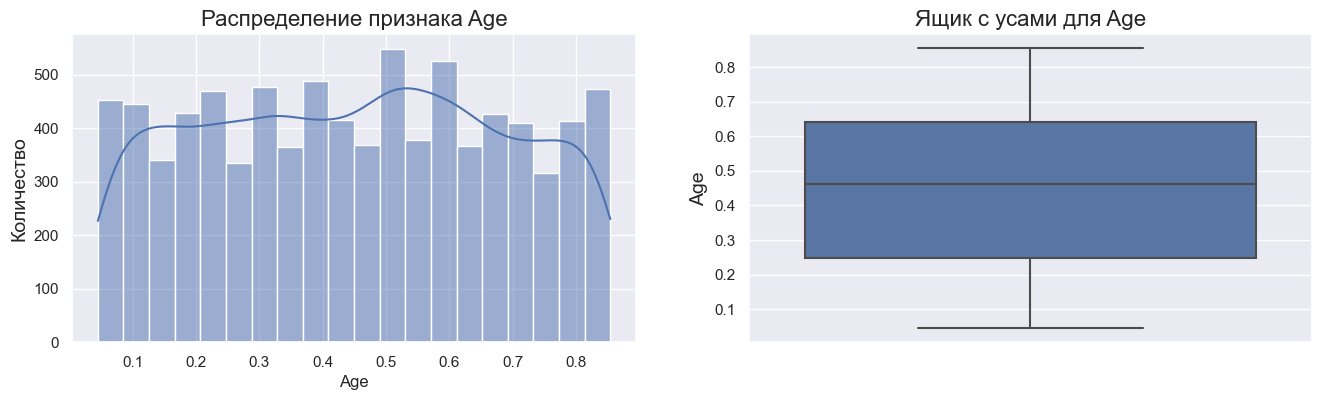

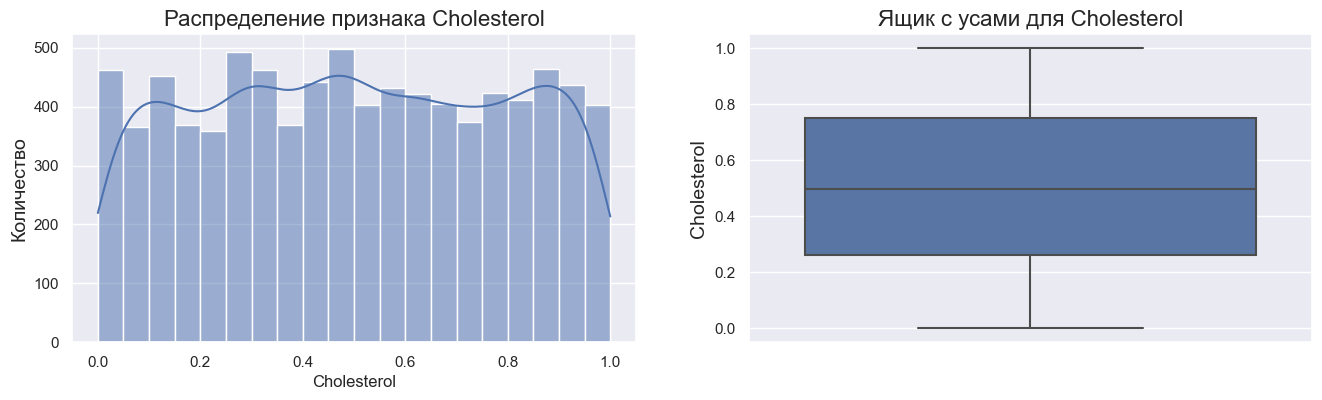

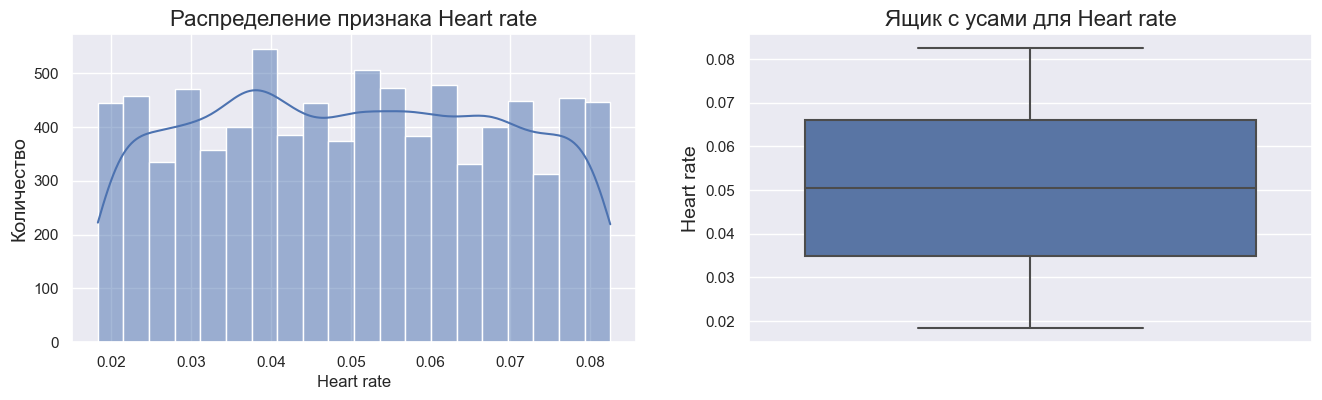

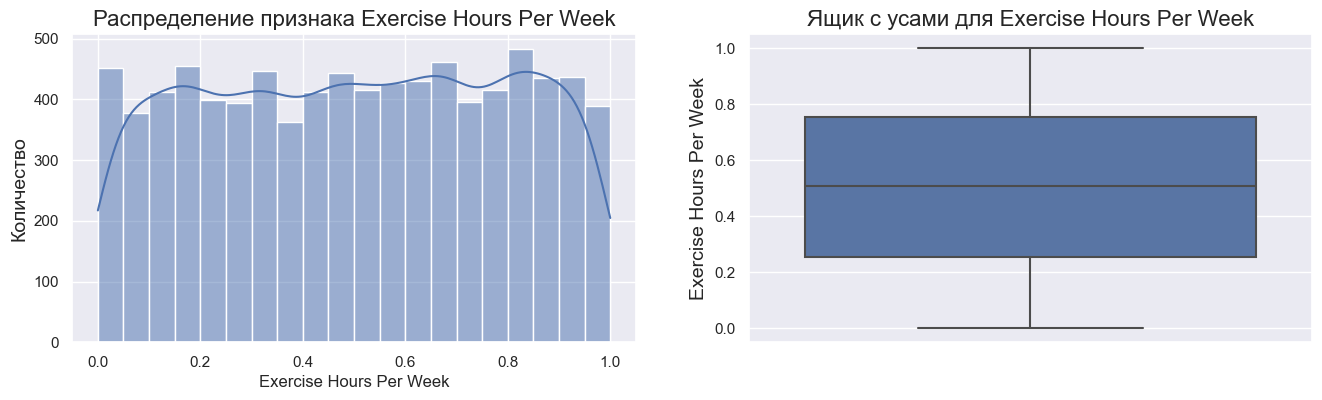

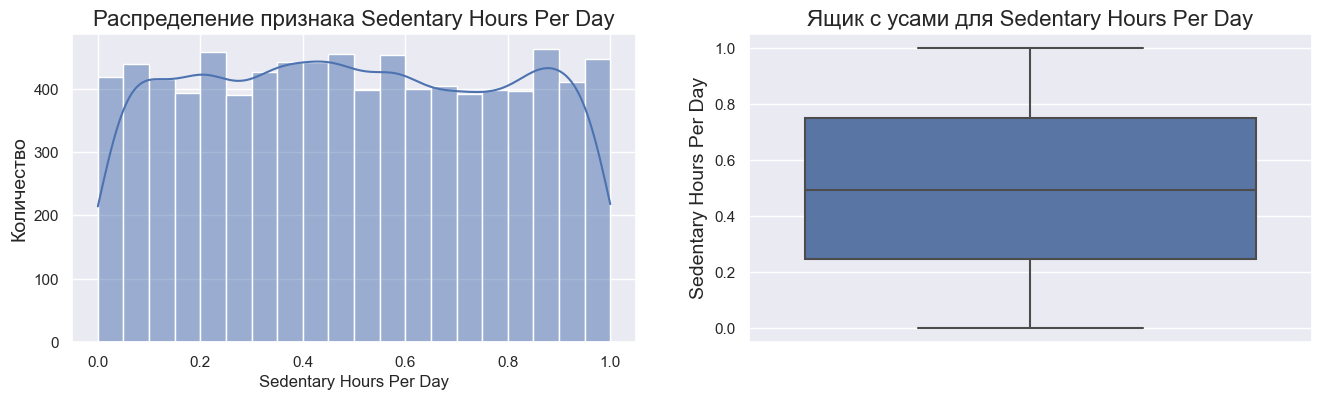

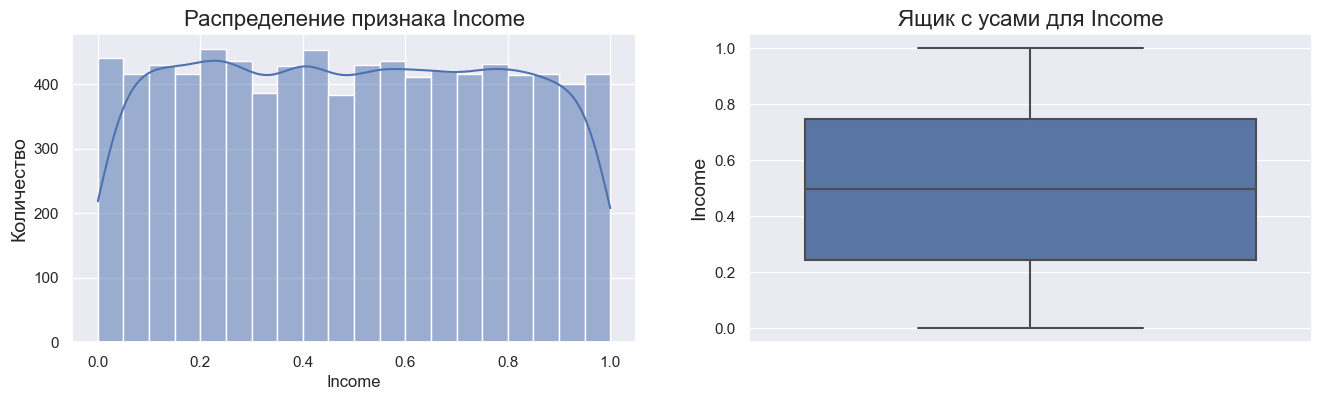

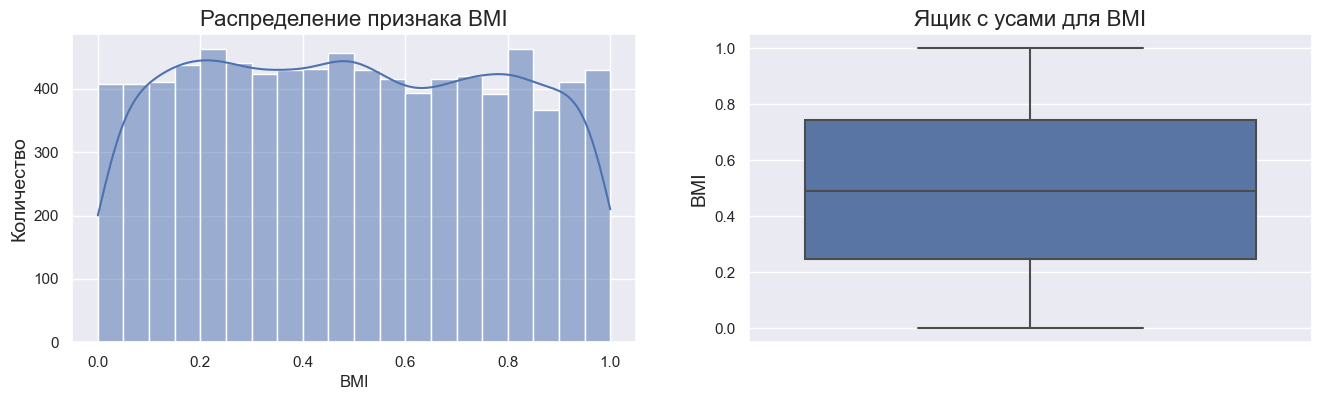

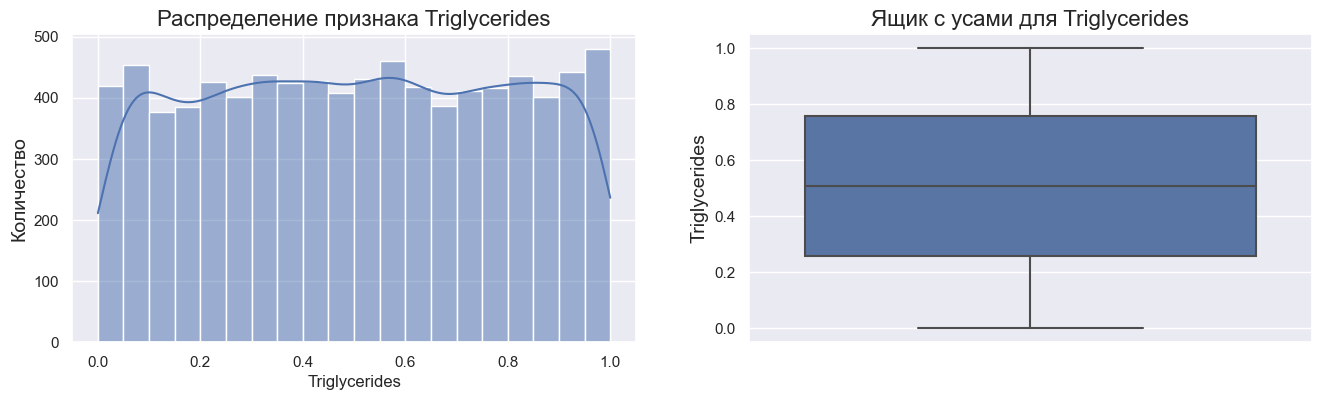

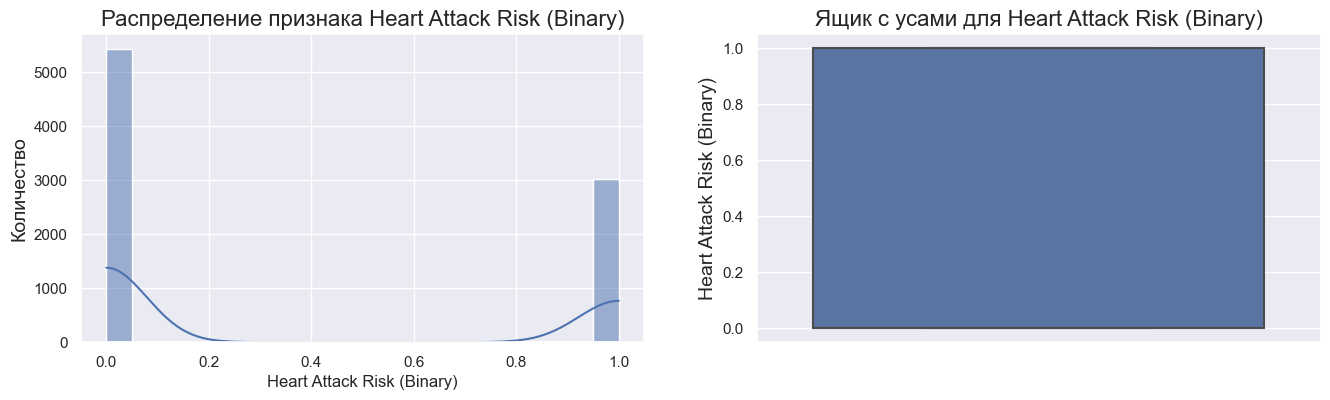

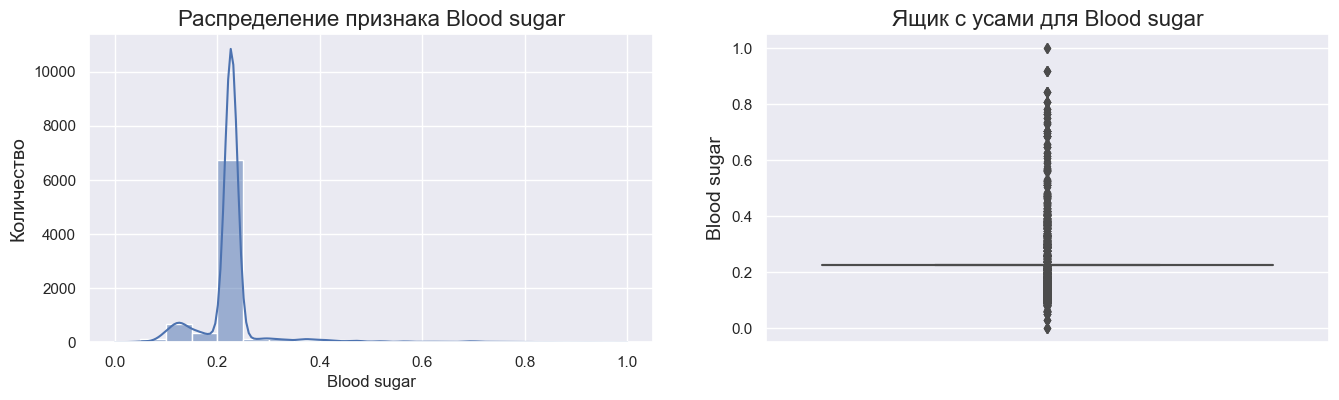

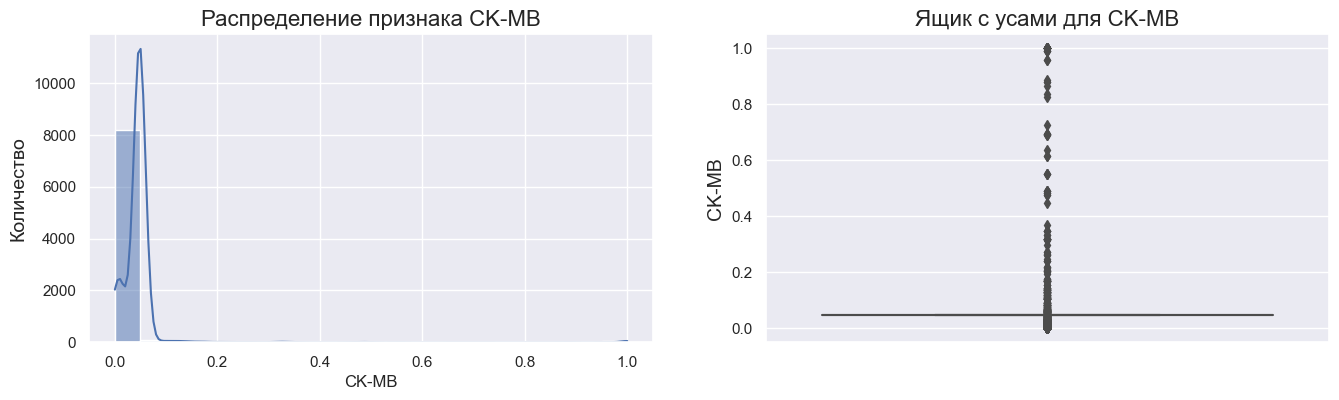

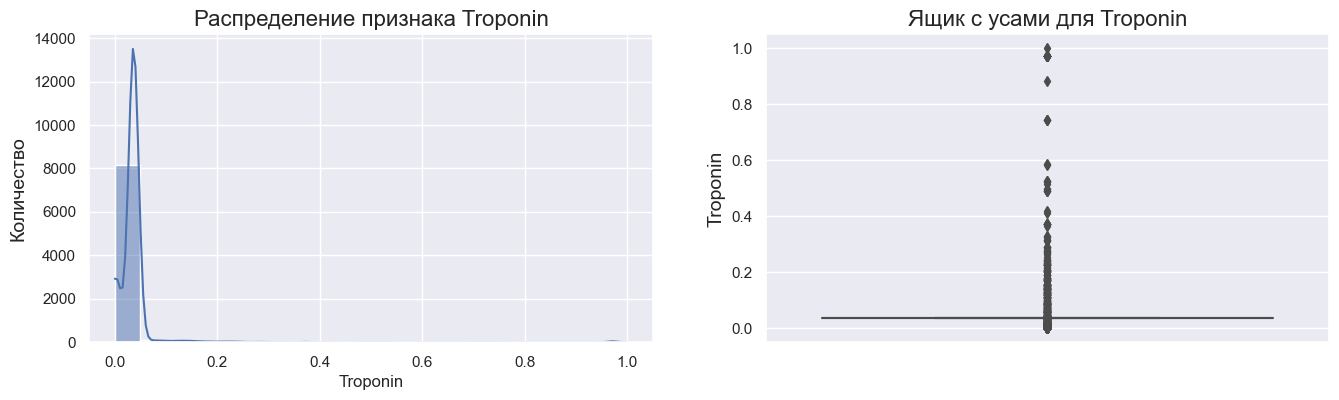

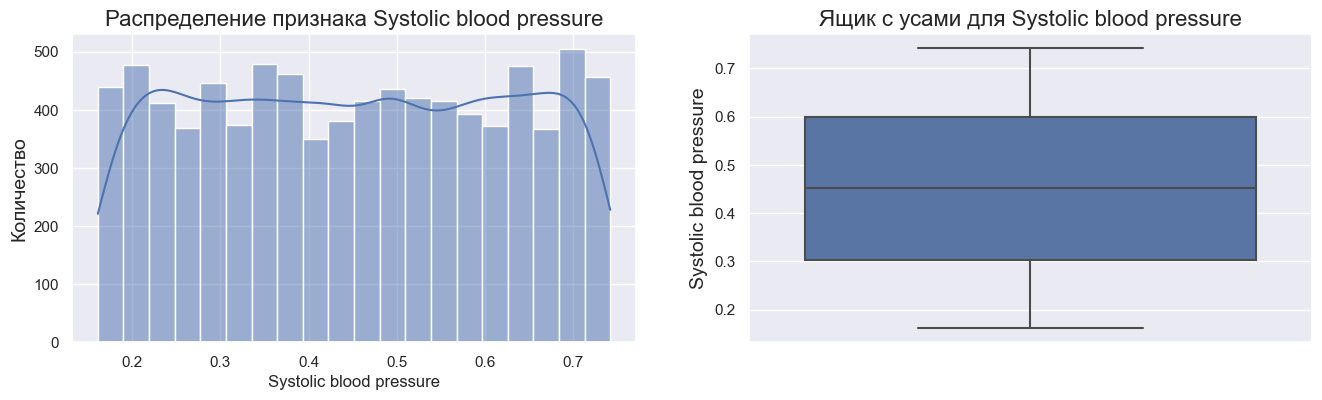

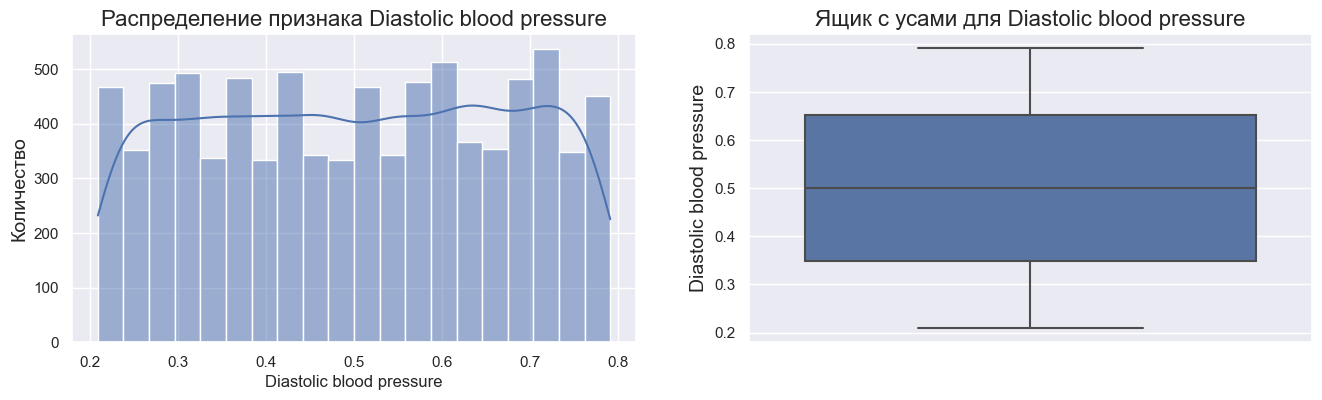

In [14]:
for col in df_train.columns:
    if col == 'id':
        continue
    if df_train[col].dtype in ['int64', 'float64']:  # –î–ª—è —á–∏—Å–ª–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö —Å—Ç—Ä–æ–∏–º –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—É
        plot_histogram_with_boxplot(df_train, col)

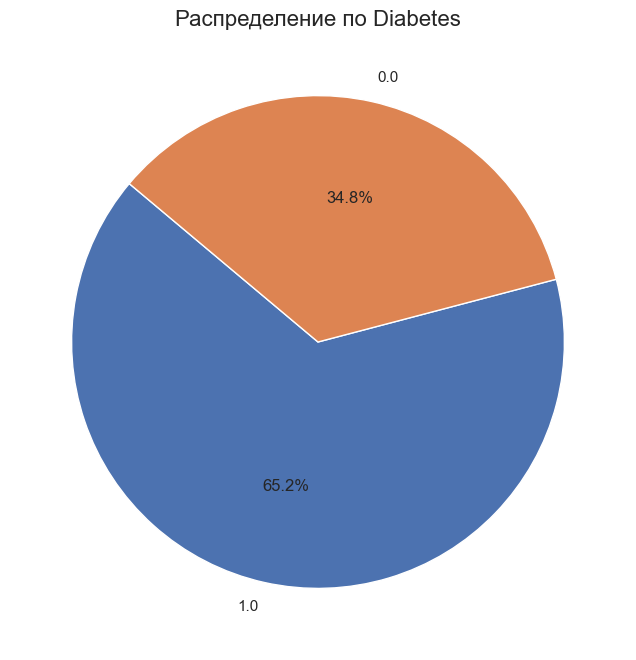

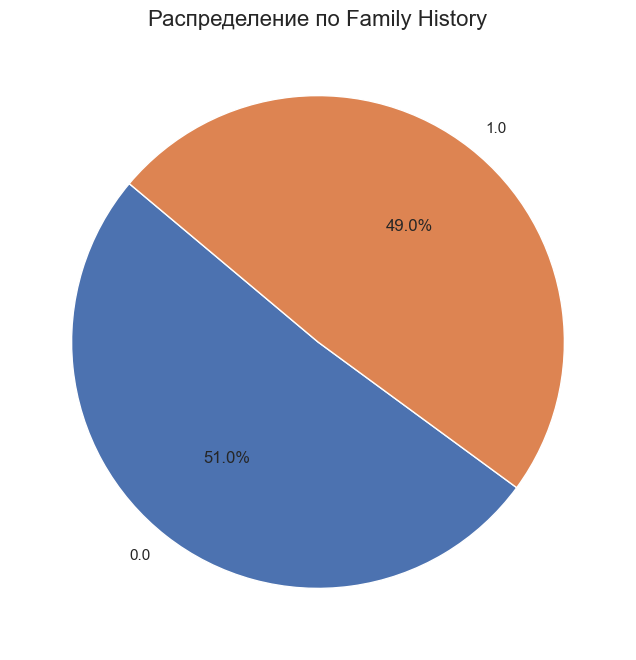

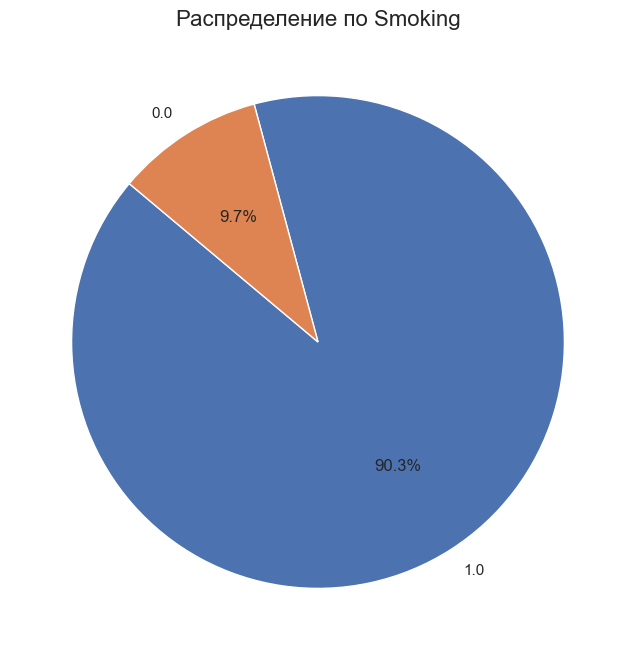

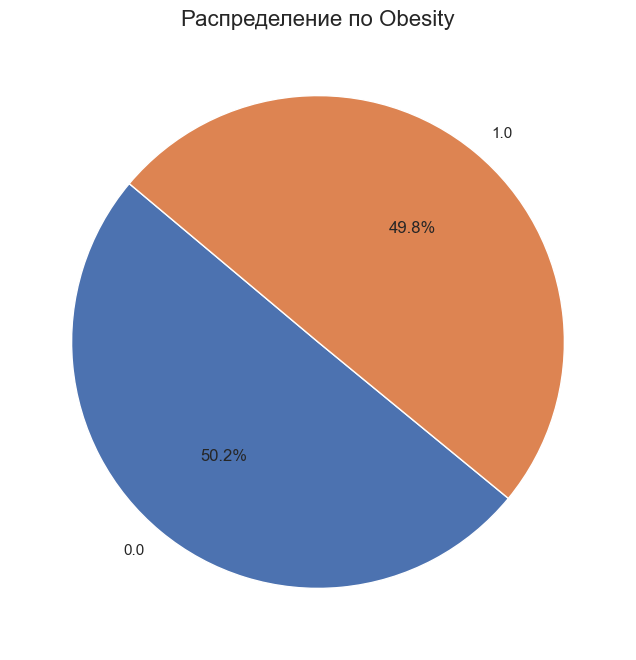

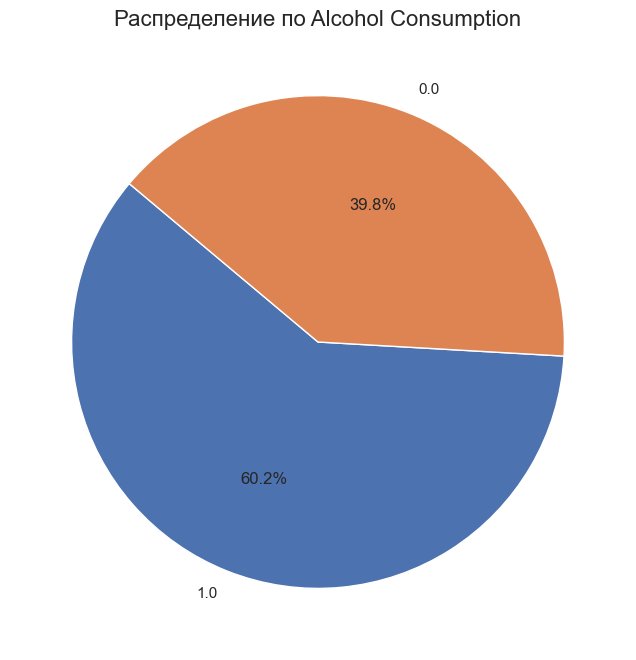

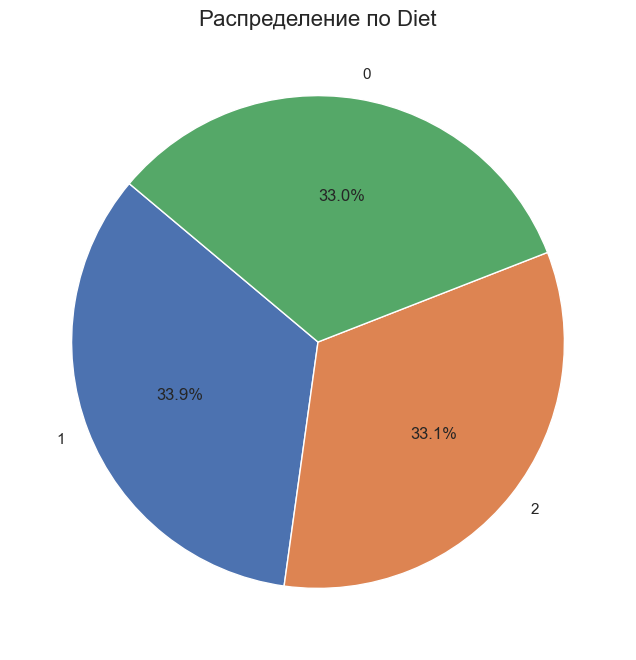

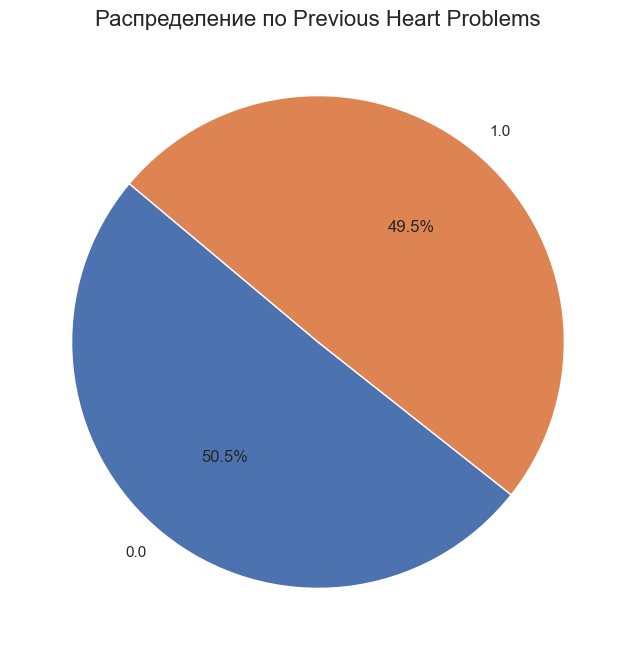

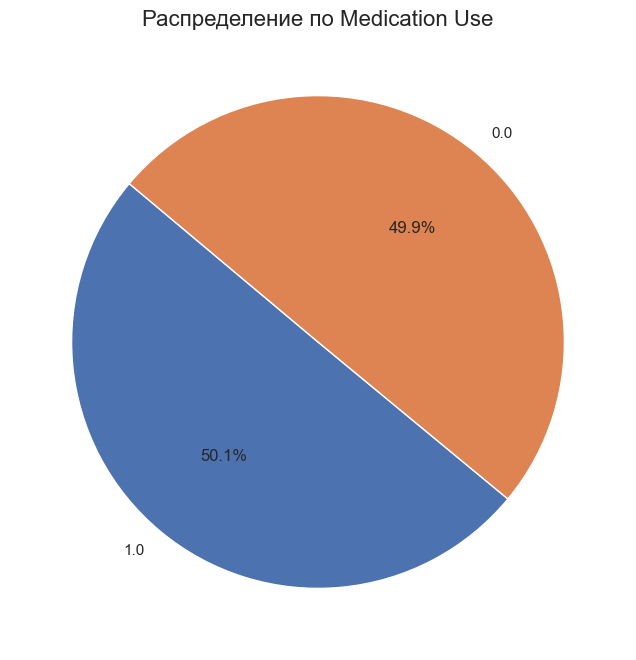

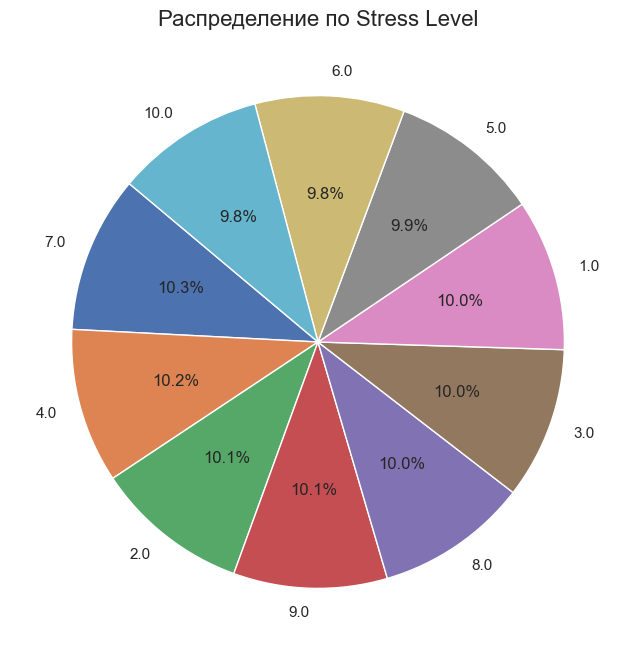

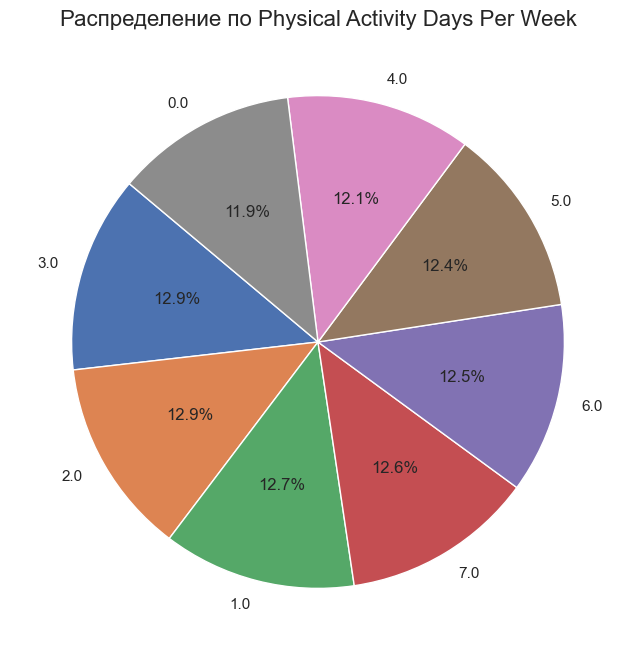

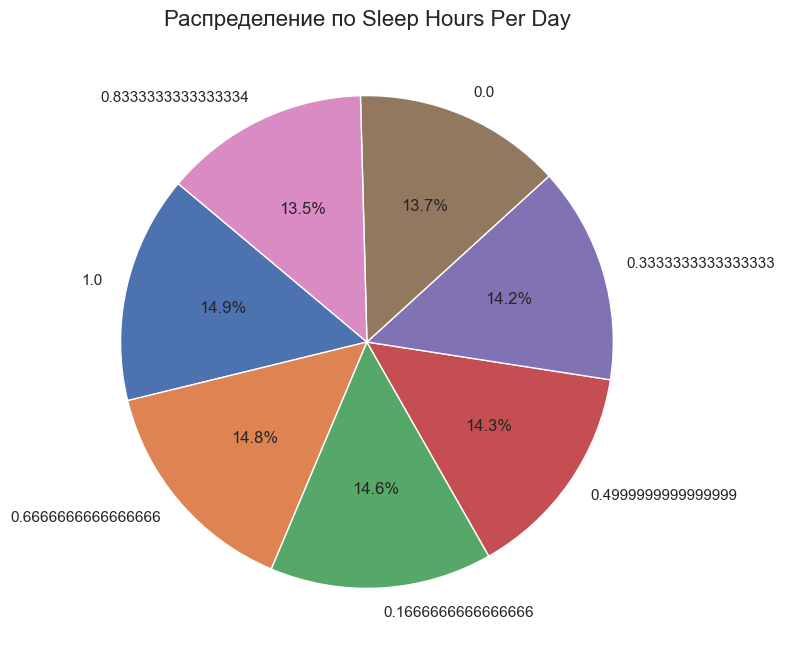

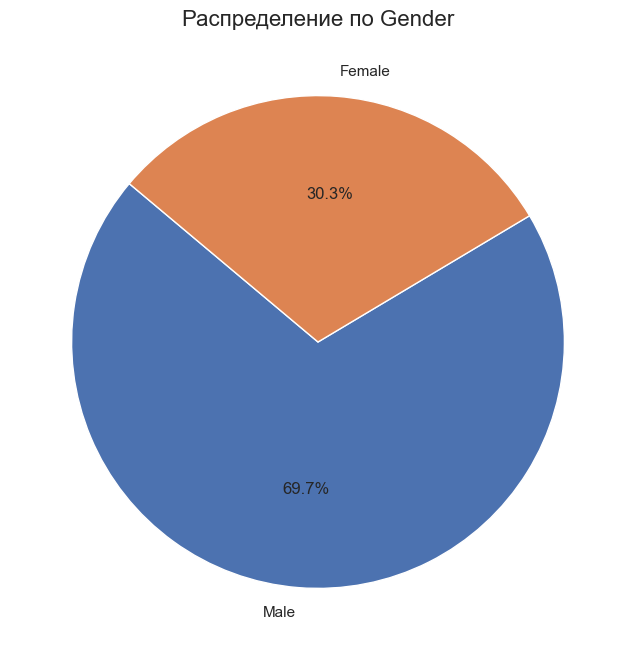

In [15]:
for col in df_train.columns:
    if col == 'id':
        continue
    if df_train[col].dtype in ['object', 'category']:  # –î–ª—è –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö —Å—Ç—Ä–æ–∏–º –∫—Ä—É–≥–æ–≤—É—é –¥–∏–∞–≥—Ä–∞–º–º—É
        plot_pivot_pie_chart(df_train, col)

In [16]:
# 4. –ê–Ω–∞–ª–∏–∑ –≤–∞–∂–Ω–æ—Å—Ç–∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (—á–µ—Ä–µ–∑ mutual information)
cat_cols = df_train.drop(['id', 'Heart Attack Risk (Binary)'], axis=1).columns # , 'object'
mi_scores = mutual_info_classif(df_train[cat_cols], df_train['Heart Attack Risk (Binary)'], discrete_features=True)
mi_df = pd.DataFrame({'Feature': cat_cols, 'MI_Score': mi_scores})
mi_df = mi_df.sort_values('MI_Score', ascending=False)
print("\n–í–∞–∂–Ω–æ—Å—Ç—å –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:\n", mi_df)


–í–∞–∂–Ω–æ—Å—Ç—å –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:
                             Feature      MI_Score
8           Exercise Hours Per Week  6.516172e-01
15                              BMI  6.516172e-01
13          Sedentary Hours Per Day  6.516172e-01
14                           Income  6.411880e-01
16                    Triglycerides  5.627593e-02
20                            CK-MB  4.503116e-02
21                         Troponin  2.214910e-02
1                       Cholesterol  1.896314e-02
19                      Blood sugar  1.498295e-02
23          Systolic blood pressure  6.400133e-03
2                        Heart rate  4.613199e-03
0                               Age  4.480394e-03
24         Diastolic blood pressure  3.273184e-03
17  Physical Activity Days Per Week  5.012027e-04
12                     Stress Level  4.584324e-04
18              Sleep Hours Per Day  3.436277e-04
9                              Diet  1.831610e-04
3                          Diabe

In [17]:
# –í—ã–±–∏—Ä–∞–µ–º —Ç–æ–ª—å–∫–æ —á–∏—Å–ª–æ–≤—ã–µ —Å—Ç–æ–ª–±—Ü—ã
numeric_cols = df_train.drop(['id', 'Heart Attack Risk (Binary)', 'Gender'], axis=1).columns # , 'object'

# –î–µ–ª–∞–µ–º DataFrame —Ç–æ–ª—å–∫–æ —Å —á–∏—Å–ª–æ–≤—ã–º–∏ –¥–∞–Ω–Ω—ã–º–∏
X = df_train[numeric_cols]

X = sm.add_constant(X)

# –†–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ–º VIF –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Å—Ç–æ–ª–±—Ü–∞
vif_data = pd.DataFrame()
vif_data["–§–∞–∫—Ç–æ—Ä"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# –í—ã–≤–æ–¥–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
print(vif_data.sort_values(by="VIF", ascending=False))


                             –§–∞–∫—Ç–æ—Ä        VIF
0                             const  77.800260
1                               Age   1.188176
6                           Smoking   1.187305
22                         Troponin   1.004919
2                       Cholesterol   1.004819
20                      Blood sugar   1.004456
14          Sedentary Hours Per Day   1.003731
13                     Stress Level   1.003598
24         Diastolic blood pressure   1.003435
7                           Obesity   1.002910
11          Previous Heart Problems   1.002759
19              Sleep Hours Per Day   1.002757
9           Exercise Hours Per Week   1.002668
4                          Diabetes   1.002661
18  Physical Activity Days Per Week   1.002634
10                             Diet   1.002530
17                    Triglycerides   1.002454
8               Alcohol Consumption   1.002357
23          Systolic blood pressure   1.002310
3                        Heart rate   1.002236
5      

## –ü—Ä–æ–µ—Ä–∫–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–π —Å –ø–æ–ª–æ–º (–º, –∂)

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8442 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Age                              8442 non-null   float64 
 1   Cholesterol                      8442 non-null   float64 
 2   Heart rate                       8442 non-null   float64 
 3   Diabetes                         8442 non-null   category
 4   Family History                   8442 non-null   category
 5   Smoking                          8442 non-null   category
 6   Obesity                          8442 non-null   category
 7   Alcohol Consumption              8442 non-null   category
 8   Exercise Hours Per Week          8442 non-null   float64 
 9   Diet                             8442 non-null   category
 10  Previous Heart Problems          8442 non-null   category
 11  Medication Use                   8442 non-null   category
 12  Stress

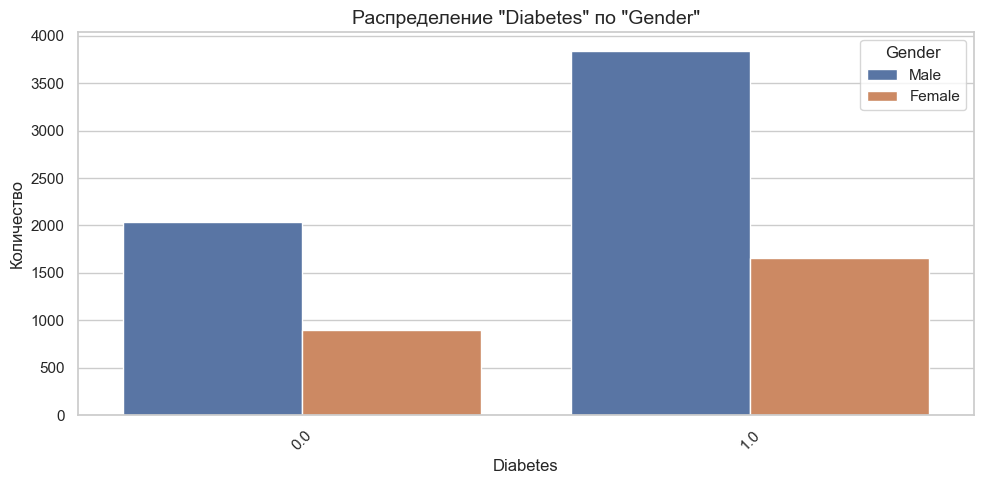

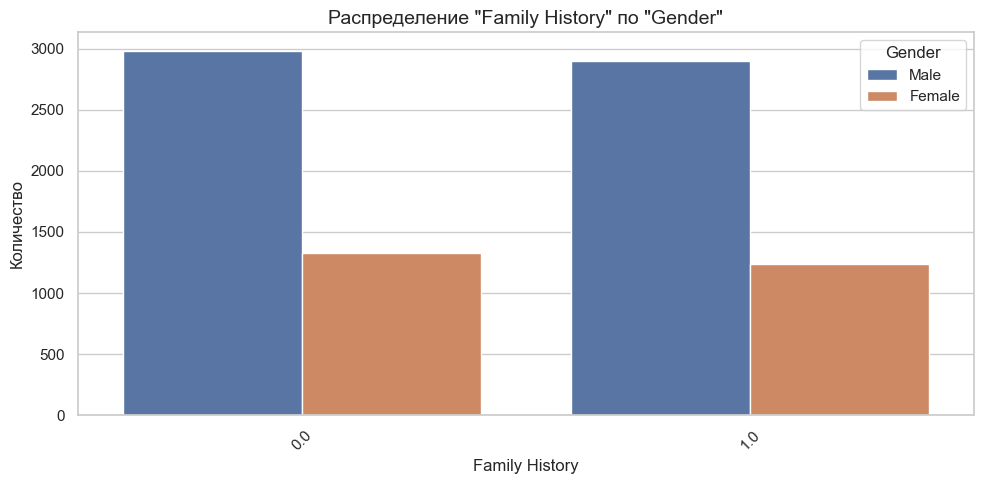

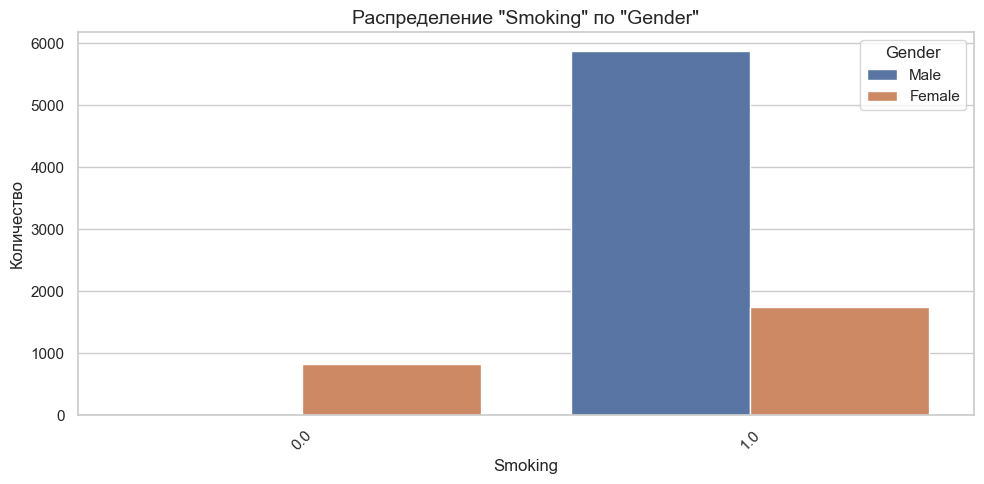

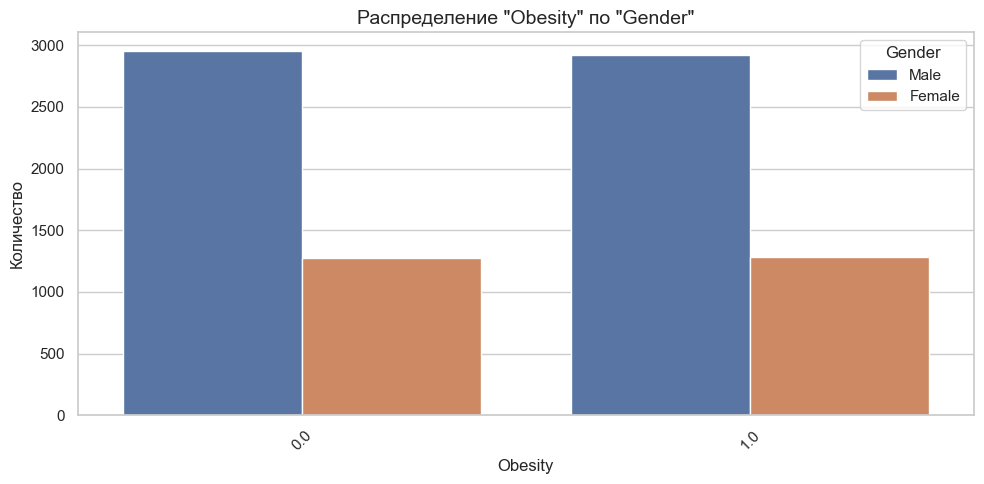

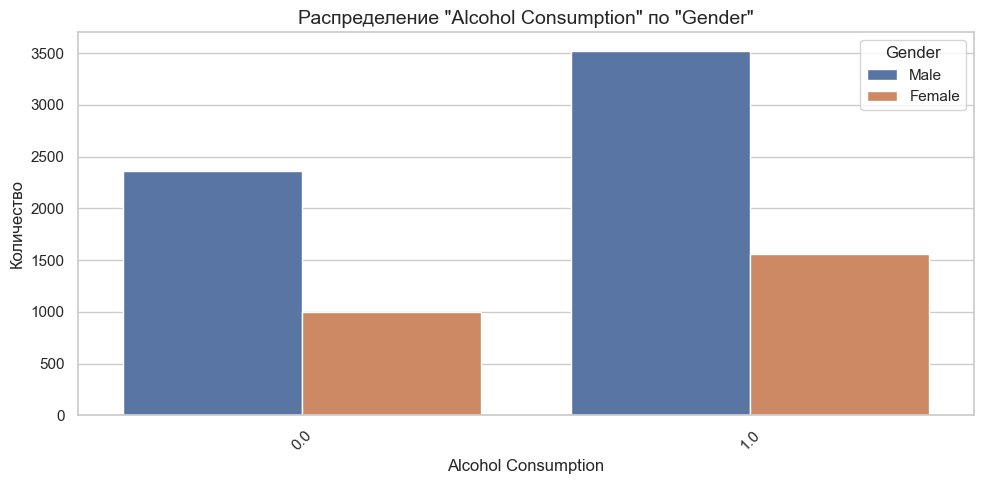

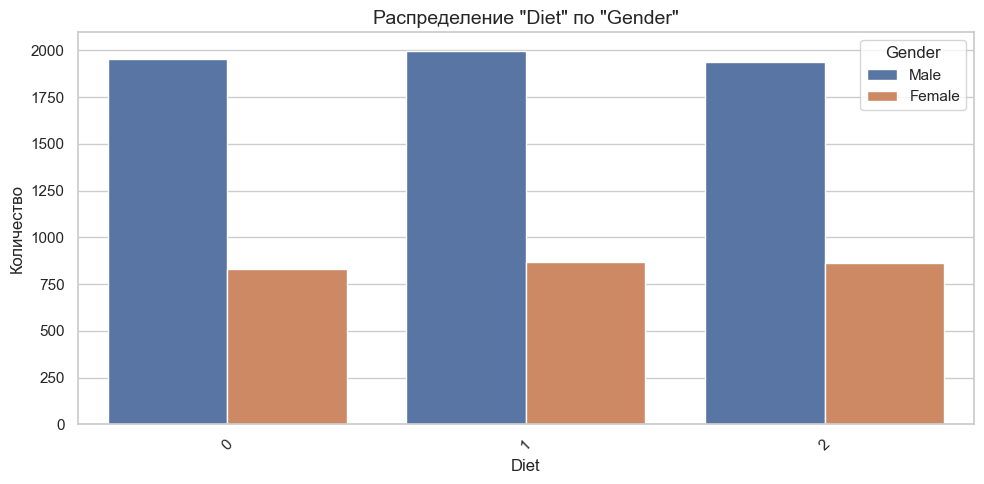

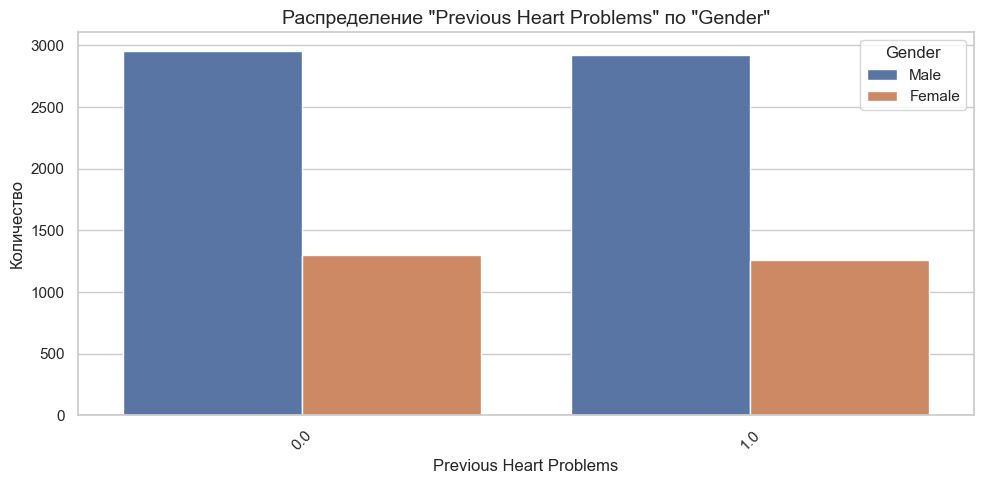

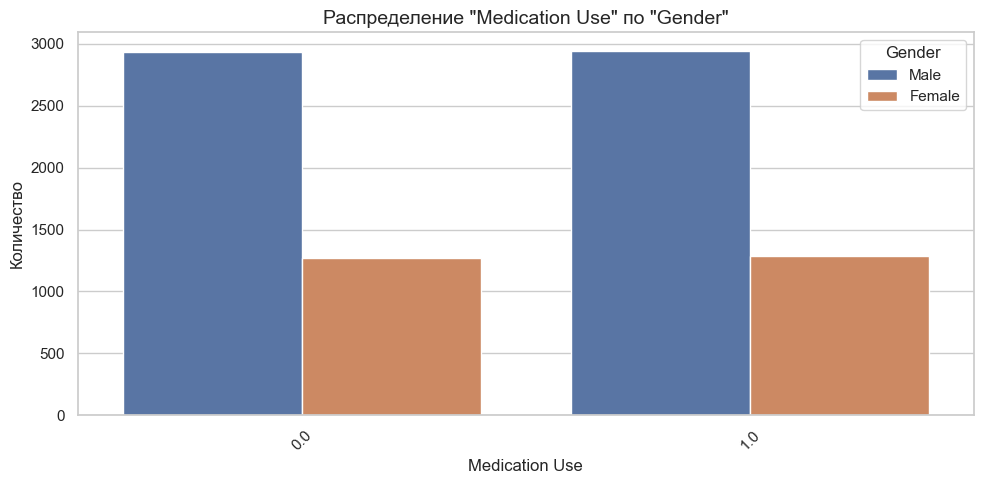

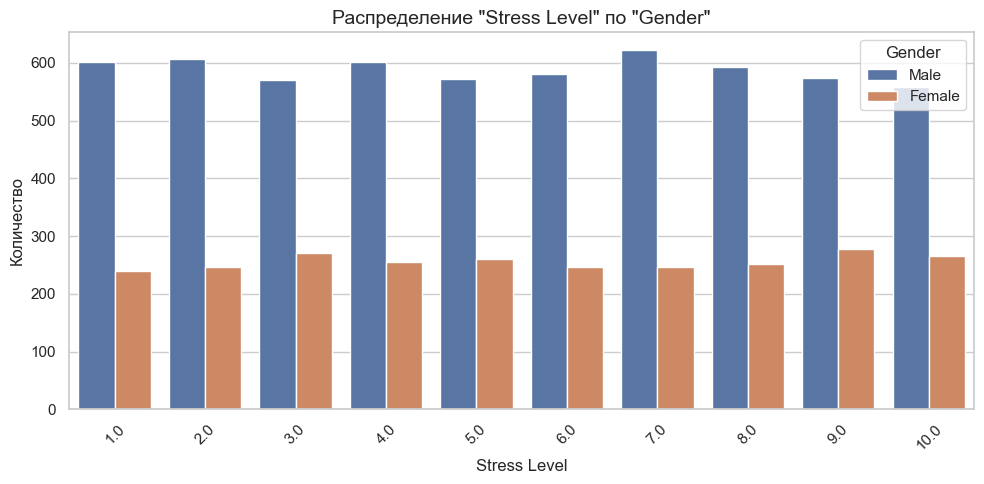

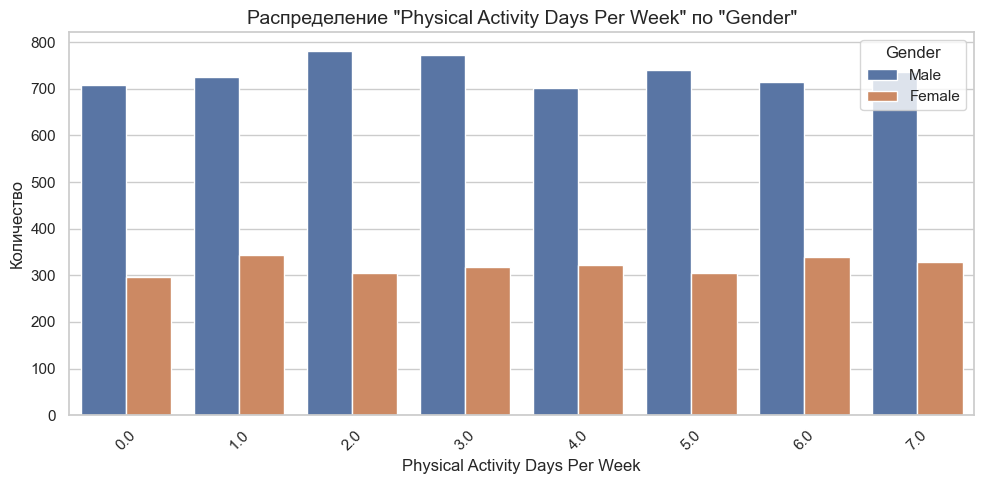

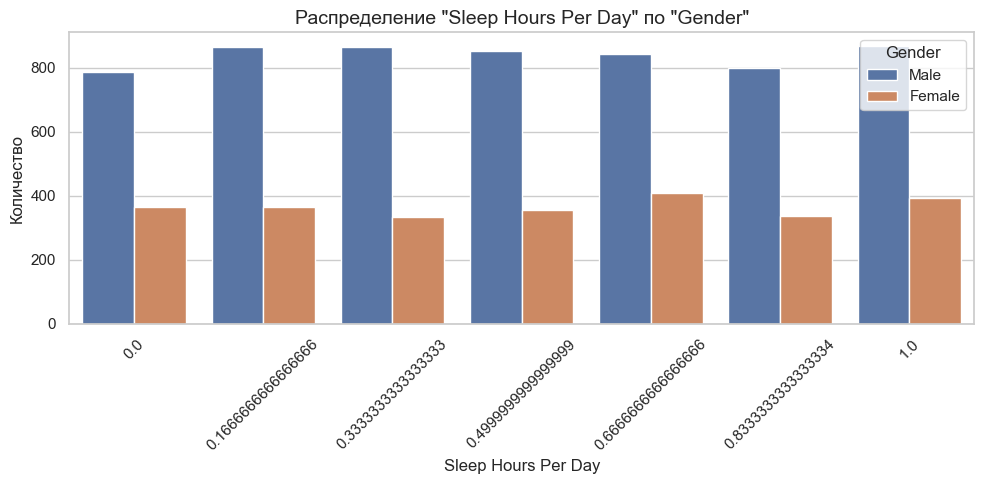

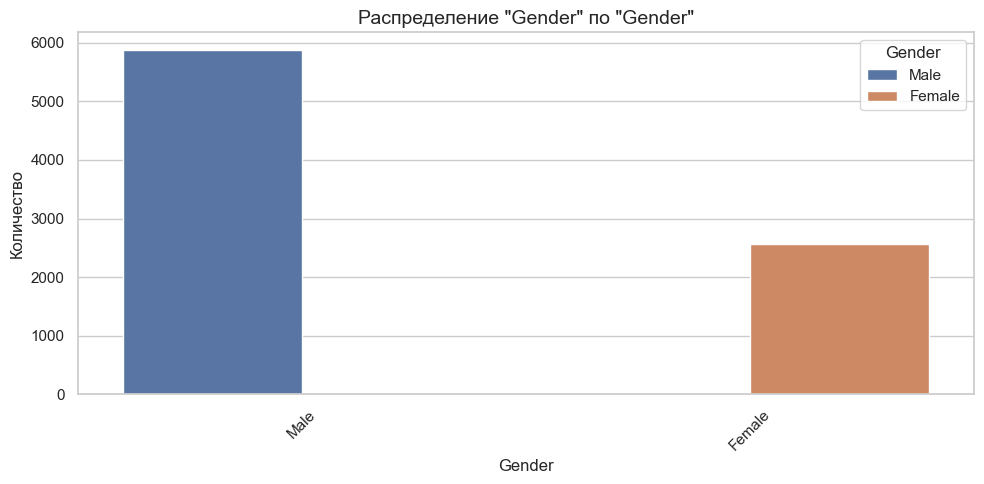

In [19]:
for col in df_train.columns:
    if col == 'id':
        continue
    if df_train[col].dtype in ['object', 'category']:  # –î–ª—è —á–∏—Å–ª–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö —Å—Ç—Ä–æ–∏–º –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—É
        plot_simple_barplot(df_train, col, 'Gender')

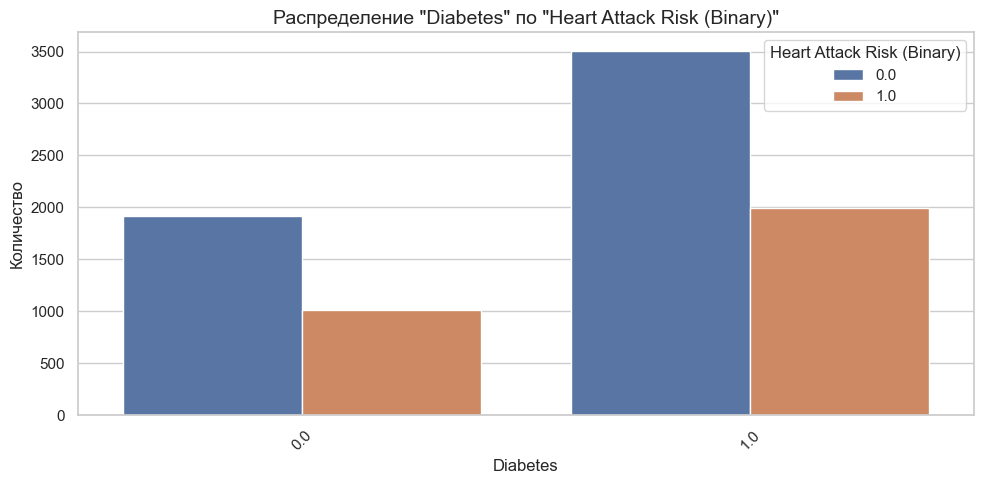

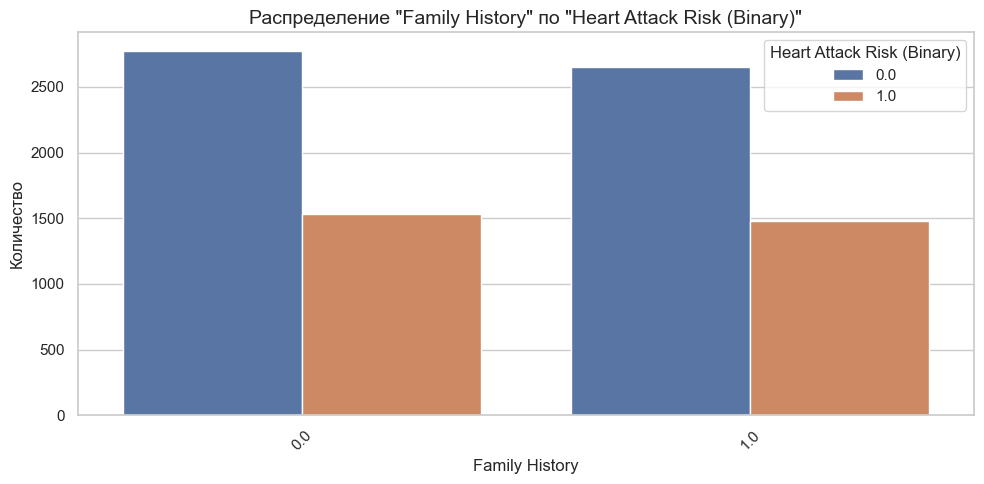

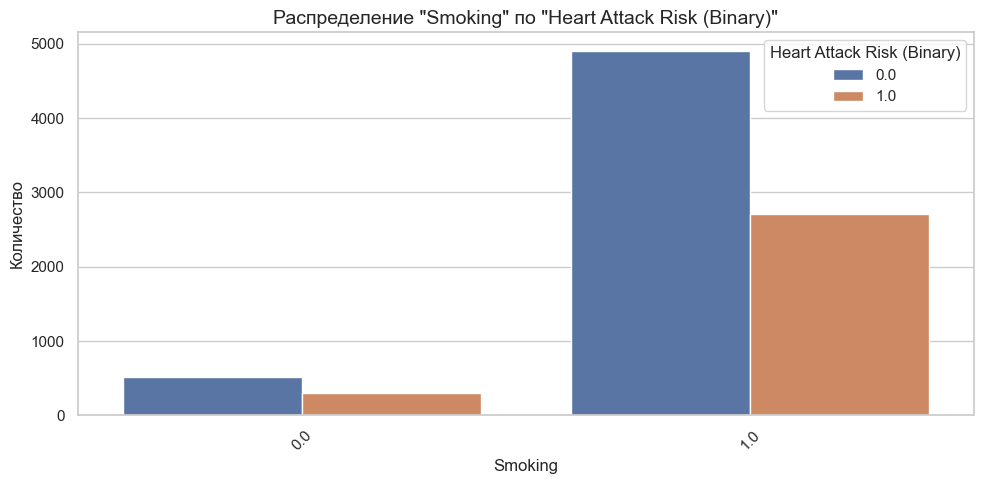

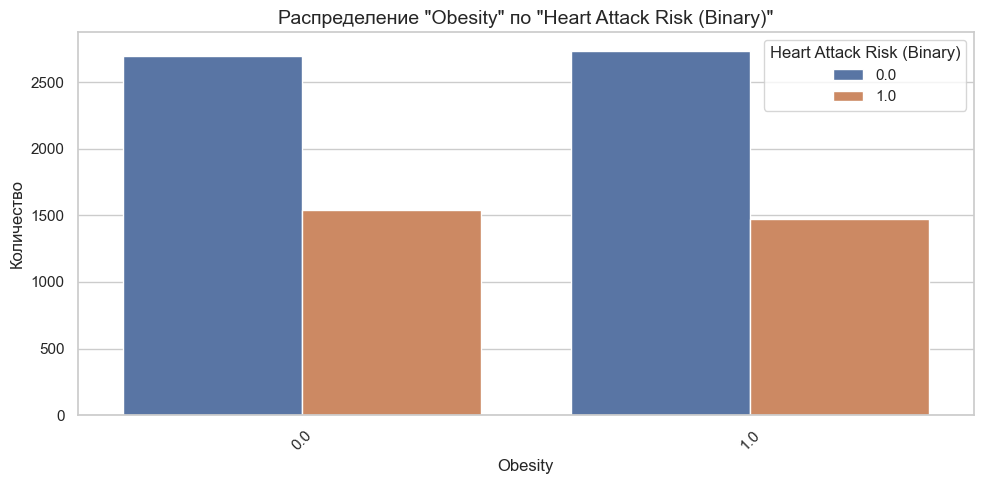

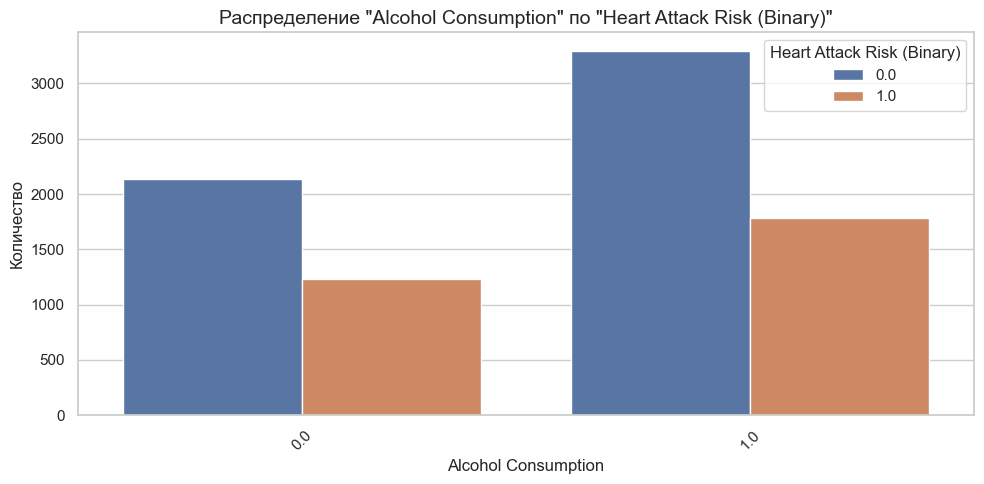

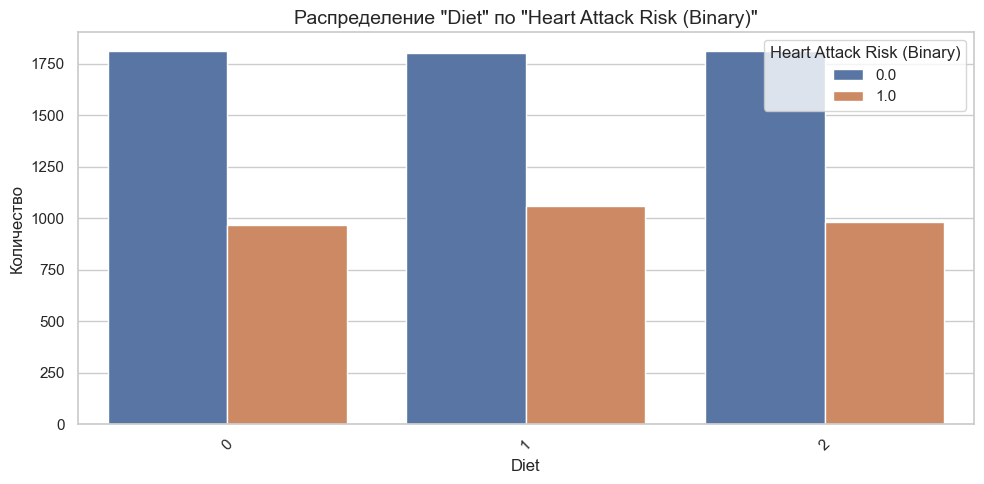

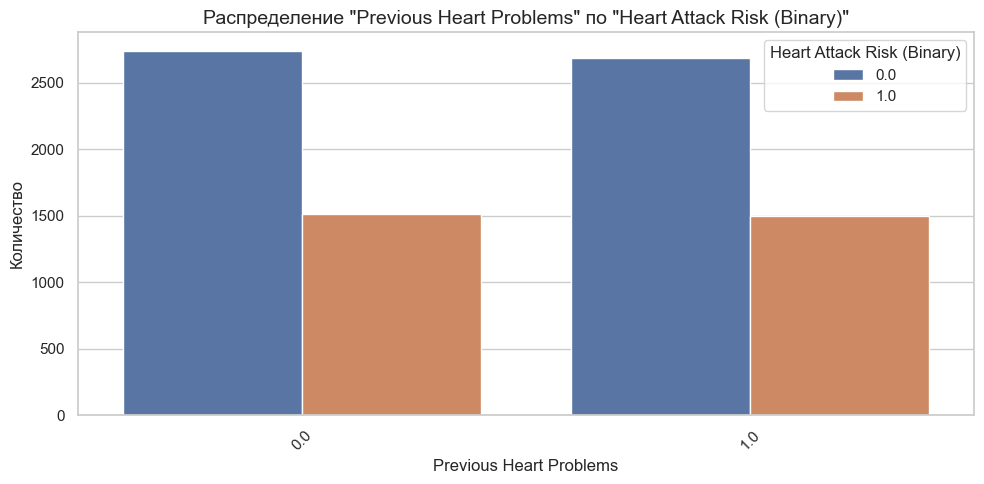

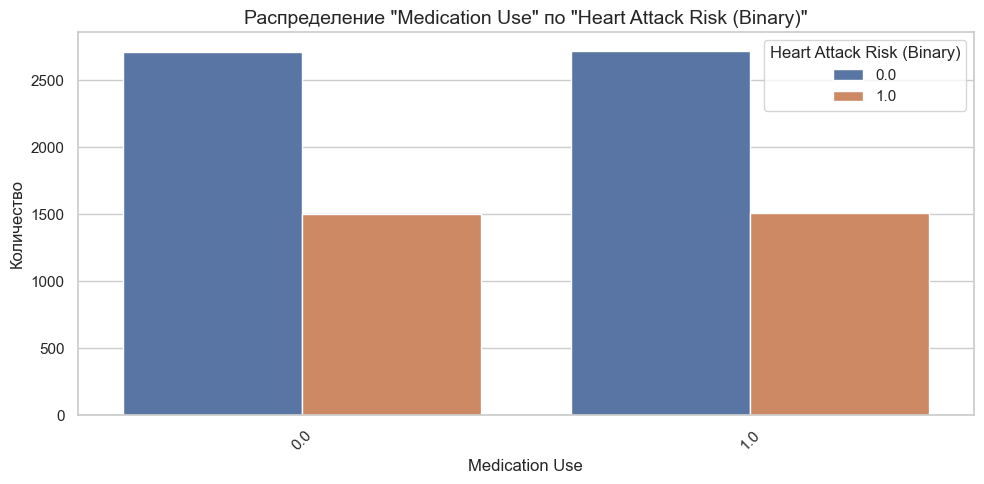

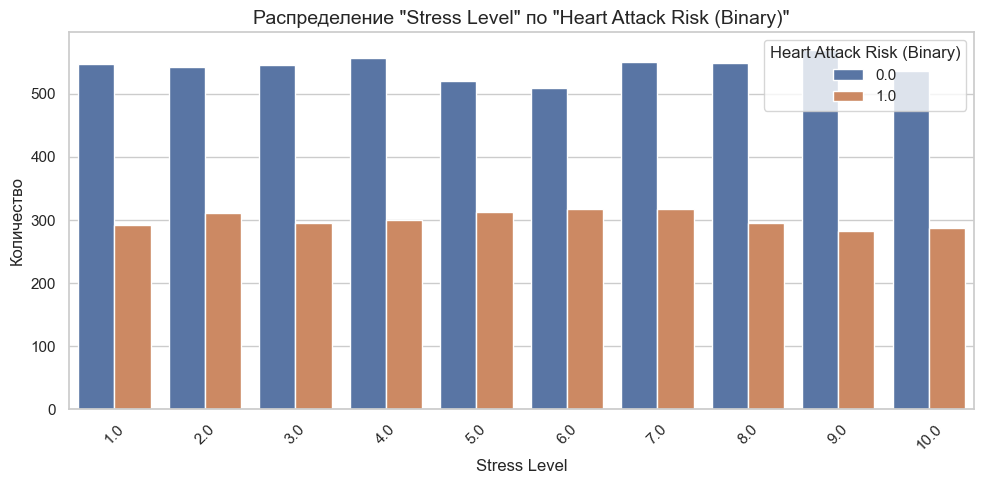

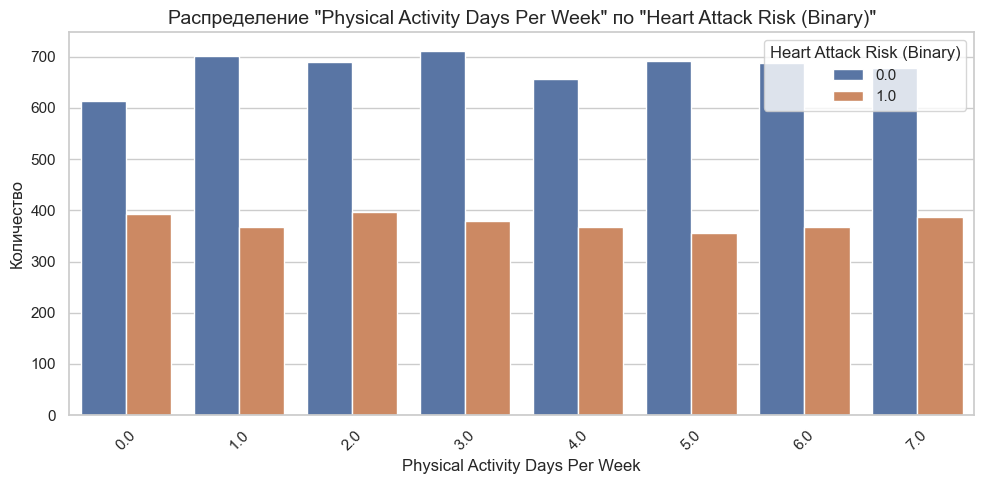

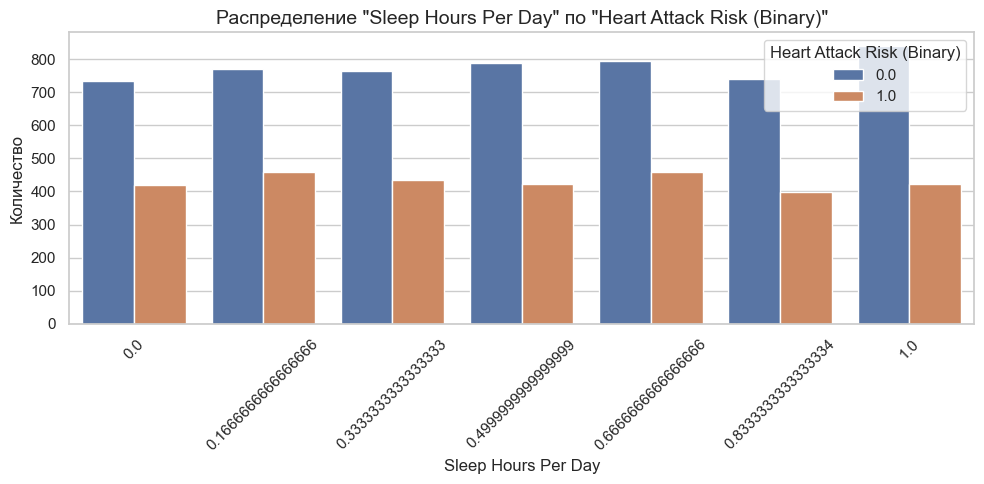

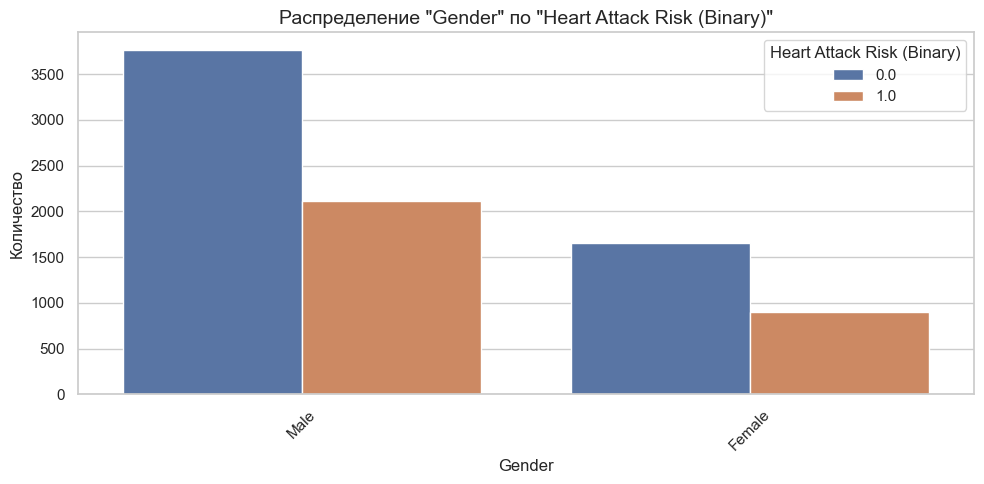

In [20]:
for col in df_train.columns:
    if col == 'id':
        continue
    if df_train[col].dtype in ['object', 'category']:  # –î–ª—è —á–∏—Å–ª–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö —Å—Ç—Ä–æ–∏–º –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—É
        plot_simple_barplot(df_train, col, 'Heart Attack Risk (Binary)')

In [21]:
df_train = df_train.drop(['Smoking', 'Blood sugar', 'CK-MB', 'Troponin'], axis=1)

## –ö—Ä–∞—Ç–∫–∏–π –≤—ã–≤–æ–¥ –ø–æ –±–ª–æ–∫—É –∏—Å—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å—Å–∫–æ–≥–æ –∞–Ω–∞–ª–∏–∑–∞ –¥–∞–Ω–Ω—ã—Ö (EDA)
–í —Ö–æ–¥–µ –∏—Å—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å—Å–∫–æ–≥–æ –∞–Ω–∞–ª–∏–∑–∞ –¥–∞–Ω–Ω—ã—Ö –±—ã–ª–∏ –∏–∑—É—á–µ–Ω—ã –æ—Å–Ω–æ–≤–Ω—ã–µ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏ –¥–∞—Ç–∞—Å–µ—Ç–∞:
- –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:
    - –ë—ã–ª–∏ –ø–æ—Å—Ç—Ä–æ–µ–Ω—ã –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—ã –∏ –±–æ–∫—Å–ø–ª–æ—Ç—ã –¥–ª—è —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤, —á—Ç–æ –ø–æ–∑–≤–æ–ª–∏–ª–æ –≤—ã—è–≤–∏—Ç—å –≤—ã–±—Ä–æ—Å—ã, –∞–Ω–æ–º–∞–ª–∏–∏ –∏ –æ—Å–æ–±–µ–Ω–Ω–æ—Å—Ç–∏ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è (–Ω–∞–ø—Ä–∏–º–µ—Ä, —Å–º–µ—â—ë–Ω–Ω–æ—Å—Ç—å, –Ω–∞–ª–∏—á–∏–µ –ø–∏–∫–æ–≤, –∞—Å–∏–º–º–µ—Ç—Ä–∏—é).
- –ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏:
    - –ü—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä–æ–≤–∞–Ω–æ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö, –≤—ã—è–≤–ª–µ–Ω—ã –Ω–µ—Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –∫–ª–∞—Å—Å—ã (–Ω–∞–ø—Ä–∏–º–µ—Ä, –ø—Ä–µ–æ–±–ª–∞–¥–∞–Ω–∏–µ –æ–¥–Ω–æ–≥–æ –∑–Ω–∞—á–µ–Ω–∏—è –Ω–∞–¥ –¥—Ä—É–≥–∏–º).
- –ö–æ—Ä—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω—ã–π –∞–Ω–∞–ª–∏–∑:
    - –ü–æ—Å—Ç—Ä–æ–µ–Ω–∞ –º–∞—Ç—Ä–∏—Ü–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π –º–µ–∂–¥—É –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏ –∏ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π. –í—ã—è–≤–ª–µ–Ω—ã –Ω–∞–∏–±–æ–ª–µ–µ –∑–Ω–∞—á–∏–º—ã–µ —Ñ–∞–∫—Ç–æ—Ä—ã, –≤–ª–∏—è—é—â–∏–µ –Ω–∞ —Ä–∏—Å–∫ —Å–µ—Ä–¥–µ—á–Ω–æ–≥–æ –ø—Ä–∏—Å—Ç—É–ø–∞ (–Ω–∞–ø—Ä–∏–º–µ—Ä, –≤–æ–∑—Ä–∞—Å—Ç, —É—Ä–æ–≤–µ–Ω—å —Ö–æ–ª–µ—Å—Ç–µ—Ä–∏–Ω–∞, –Ω–∞–ª–∏—á–∏–µ –¥–∏–∞–±–µ—Ç–∞ –∏ –¥—Ä.).
- –°–≤—è–∑–∏ –º–µ–∂–¥—É –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏:
    - –ë—ã–ª–∏ –æ–±–Ω–∞—Ä—É–∂–µ–Ω—ã –≤–∑–∞–∏–º–æ—Å–≤—è–∑–∏ –º–µ–∂–¥—É –Ω–µ–∫–æ—Ç–æ—Ä—ã–º–∏ –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏ (–Ω–∞–ø—Ä–∏–º–µ—Ä, –º–µ–∂–¥—É –æ–∂–∏—Ä–µ–Ω–∏–µ–º –∏ —É—Ä–æ–≤–Ω–µ–º —Ö–æ–ª–µ—Å—Ç–µ—Ä–∏–Ω–∞, –º–µ–∂–¥—É —Ñ–∏–∑–∏—á–µ—Å–∫–æ–π –∞–∫—Ç–∏–≤–Ω–æ—Å—Ç—å—é –∏ –∏–Ω–¥–µ–∫—Å–æ–º –º–∞—Å—Å—ã —Ç–µ–ª–∞).
- –ê–Ω–∞–ª–∏–∑ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π:
    - –û—Ü–µ–Ω–µ–Ω–æ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π (Heart Attack Risk), –≤—ã—è–≤–ª–µ–Ω –¥–∏—Å–±–∞–ª–∞–Ω—Å –∫–ª–∞—Å—Å–æ–≤, —á—Ç–æ –≤–∞–∂–Ω–æ —É—á–∏—Ç—ã–≤–∞—Ç—å –ø—Ä–∏ –æ–±—É—á–µ–Ω–∏–∏ –º–æ–¥–µ–ª–∏.

**–û–±—â–∏–π –≤—ã–≤–æ–¥:**

–ò—Å—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑ –ø–æ–∑–≤–æ–ª–∏–ª –≤—ã—è–≤–∏—Ç—å –∫–ª—é—á–µ–≤—ã–µ –æ—Å–æ–±–µ–Ω–Ω–æ—Å—Ç–∏ –∏ –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª—å–Ω—ã–µ –ø—Ä–æ–±–ª–µ–º—ã –≤ –¥–∞–Ω–Ω—ã—Ö (–ø—Ä–æ–ø—É—Å–∫–∏, –≤—ã–±—Ä–æ—Å—ã, –¥–∏—Å–±–∞–ª–∞–Ω—Å –∫–ª–∞—Å—Å–æ–≤). –ü–æ–ª—É—á–µ–Ω–Ω—ã–µ –∏–Ω—Å–∞–π—Ç—ã –ª–µ–≥–ª–∏ –≤ –æ—Å–Ω–æ–≤—É –¥–∞–ª—å–Ω–µ–π—à–µ–π –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∏ –¥–∞–Ω–Ω—ã—Ö –∏ –≤—ã–±–æ—Ä–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è –º–æ–¥–µ–ª–∏ –º–∞—à–∏–Ω–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è.

# –ö–æ—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω—ã–π –∞–Ω–∞–ª–∏–∑

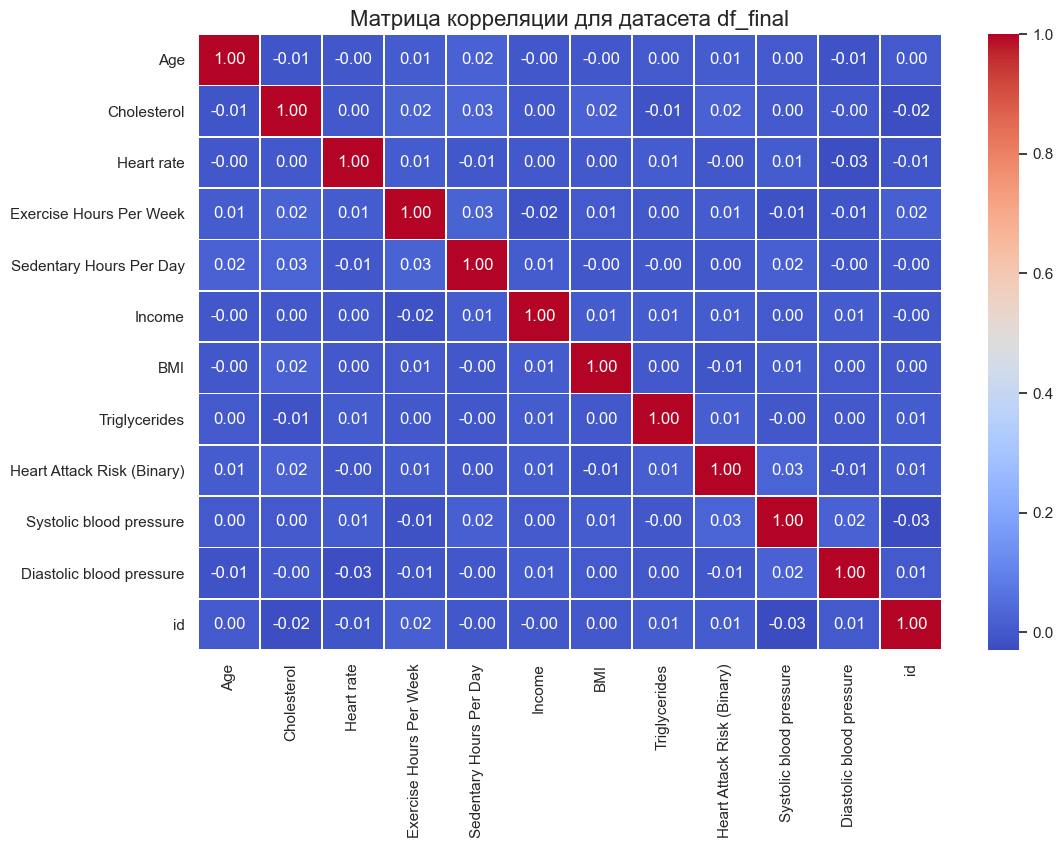

In [22]:
numeric_cols = df_train.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df_train[numeric_cols].corr()

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –≥—Ä–∞—Ñ–∏–∫–∞
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=True)

# –ó–∞–≥–æ–ª–æ–≤–æ–∫
plt.title("–ú–∞—Ç—Ä–∏—Ü–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ –¥–ª—è –¥–∞—Ç–∞—Å–µ—Ç–∞ df_final", fontsize=16)

# –ü–æ–∫–∞–∑–∞—Ç—å –≥—Ä–∞—Ñ–∏–∫
plt.show()

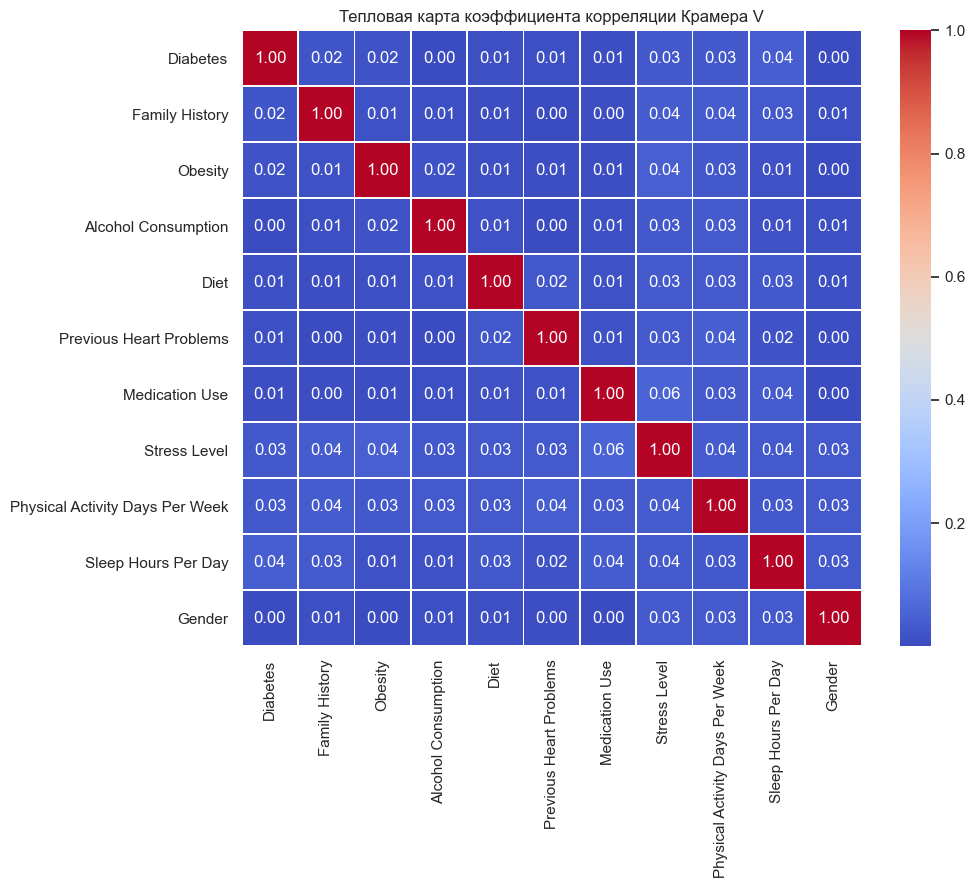

In [23]:
# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ —Å—Ç–æ–ª–±—Ü—ã –≤ —Ç–∏–ø –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
categorical_columns = df_train.select_dtypes(include=['object', 'category']).columns

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–∞ –ö—Ä–∞–º–µ—Ä–∞ V
def cramers_v(crosstab):
    chi2, p, dof, expected = chi2_contingency(crosstab)
    n = crosstab.sum().sum()
    return np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))

# –°–æ–∑–¥–∞–¥–∏–º —Ç–∞–±–ª–∏—Ü—É –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π –ö—Ä–∞–º–µ—Ä–∞ V –¥–ª—è –≤—Å–µ—Ö –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            crosstab = pd.crosstab(df_train[col1], df_train[col2])
            cramers_v_matrix.loc[col1, col2] = cramers_v(crosstab)
        else:
            cramers_v_matrix.loc[col1, col2] = 1.0  # –ü–æ–ª–Ω–∞—è –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç—å —Å —Å–æ–±–æ–π

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –∑–Ω–∞—á–µ–Ω–∏—è –≤ float –¥–ª—è —É–¥–æ–±–Ω–æ–≥–æ –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è
cramers_v_matrix = cramers_v_matrix.astype(float)

# –ü–æ—Å—Ç—Ä–æ–∏–º —Ç–µ–ø–ª–æ–≤—É—é –∫–∞—Ä—Ç—É
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('–¢–µ–ø–ª–æ–≤–∞—è –∫–∞—Ä—Ç–∞ –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ –ö—Ä–∞–º–µ—Ä–∞ V')
plt.show()


interval columns not set, guessing: ['Age', 'Cholesterol', 'Heart rate', 'Exercise Hours Per Week', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Heart Attack Risk (Binary)', 'Systolic blood pressure', 'Diastolic blood pressure']


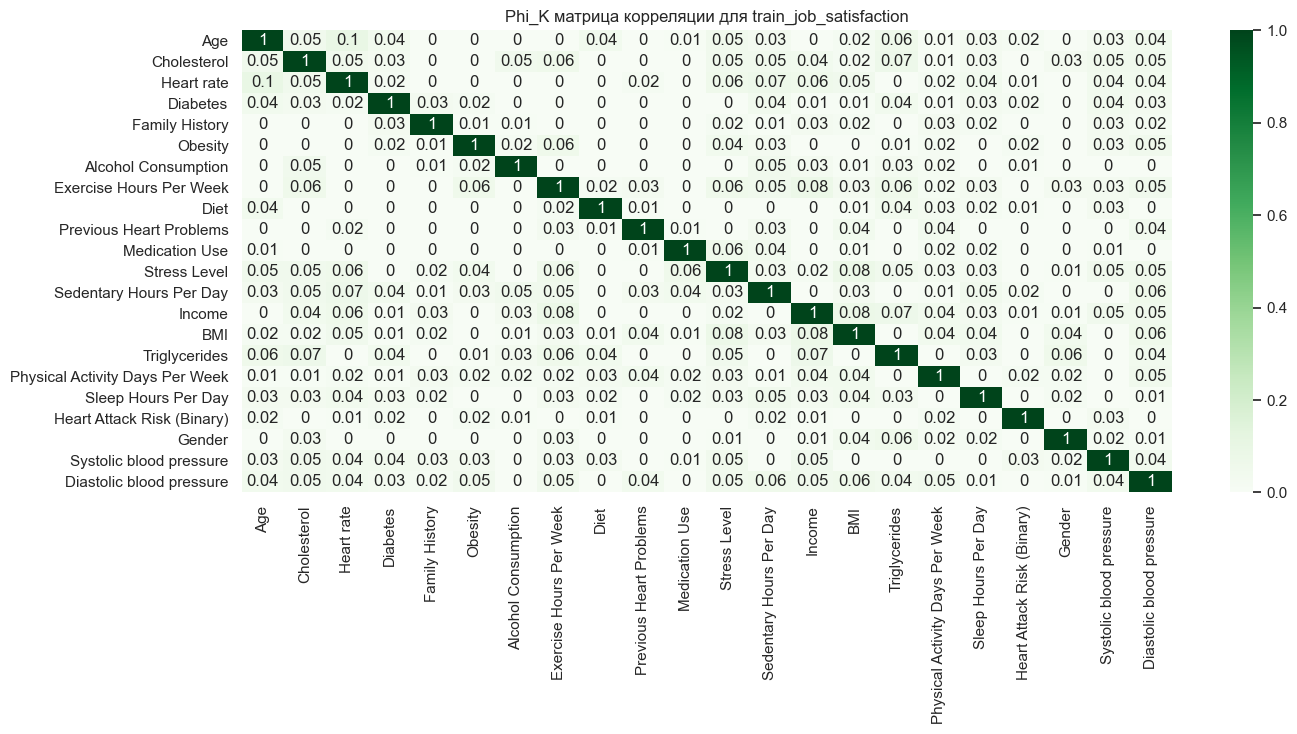

In [24]:
# –í—ã—á–∏—Å–ª—è–µ–º Phi_K –º–∞—Ç—Ä–∏—Ü—É
phik_matrix = round(df_train.drop('id', axis=1).phik_matrix(), 2)

plt.figure(figsize=(15, 6))
sns.heatmap(phik_matrix, annot=True, cmap='Greens')
plt.title('Phi_K –º–∞—Ç—Ä–∏—Ü–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ –¥–ª—è train_job_satisfaction')
plt.show()

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8442 entries, 0 to 8684
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Age                              8442 non-null   float64 
 1   Cholesterol                      8442 non-null   float64 
 2   Heart rate                       8442 non-null   float64 
 3   Diabetes                         8442 non-null   category
 4   Family History                   8442 non-null   category
 5   Obesity                          8442 non-null   category
 6   Alcohol Consumption              8442 non-null   category
 7   Exercise Hours Per Week          8442 non-null   float64 
 8   Diet                             8442 non-null   category
 9   Previous Heart Problems          8442 non-null   category
 10  Medication Use                   8442 non-null   category
 11  Stress Level                     8442 non-null   category
 12  Sedent

–ö–æ—Ä–µ—Ä–µ–ª–ª—è—Ü–∏—è –Ω–µ –≤—ã—è–≤–ª–µ–Ω–∞, —á—Ç–æ –æ—á–µ–Ω—å —Å—Ç—Ä–∞–Ω–Ω–æ :(

# –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π 

In [26]:
# best_model.save_model('best_catboost_model.cbm')

def evaluate_model_with_threshold(y_true, y_proba, threshold):
    """–û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏ —Å –∑–∞–¥–∞–Ω–Ω—ã–º –ø–æ—Ä–æ–≥–æ–º –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏"""
    # –ü—Ä–∏–º–µ–Ω—è–µ–º –ø–æ—Ä–æ–≥
    y_pred = (y_proba >= threshold).astype(int)
    
    # –ú–∞—Ç—Ä–∏—Ü–∞ –æ—à–∏–±–æ–∫
    plt.figure(figsize=(7, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['–ù–µ—Ç —Ä–∏—Å–∫–∞', '–†–∏—Å–∫'],
               yticklabels=['–ù–µ—Ç —Ä–∏—Å–∫–∞', '–†–∏—Å–∫'],
               annot_kws={"size": 14})
    plt.title(f'–ú–∞—Ç—Ä–∏—Ü–∞ –æ—à–∏–±–æ–∫ (–ü–æ—Ä–æ–≥ = {threshold:.3f})', fontsize=14)
    plt.xlabel('–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å', fontsize=12)
    plt.ylabel('–ò—Å—Ç–∏–Ω–Ω—ã–π –∫–ª–∞—Å—Å', fontsize=12)
    plt.show()
    
    # –î–µ—Ç–∞–ª–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏
    print("\n" + "="*50)
    print(f"–û—Ü–µ–Ω–∫–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ (–ø–æ—Ä–æ–≥ = {threshold:.3f})")
    print("="*50)
    
    tn, fp, fn, tp = cm.ravel()
    print(f"\nüìä –û—Å–Ω–æ–≤–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_proba):.4f}")
    
    print("\nüîç –î–µ—Ç–∞–ª–∏–∑–∞—Ü–∏—è –æ—à–∏–±–æ–∫:")
    print(f"True Negatives (TN): {tn} | –ü—Ä–∞–≤–∏–ª—å–Ω–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ '–ù–µ—Ç —Ä–∏—Å–∫–∞'")
    print(f"False Positives (FP): {fp} | –õ–æ–∂–Ω—ã–µ —Ç—Ä–µ–≤–æ–≥–∏")
    print(f"False Negatives (FN): {fn} | –ü—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ —Å–ª—É—á–∞–∏ —Ä–∏—Å–∫–∞")
    print(f"True Positives (TP): {tp} | –ü—Ä–∞–≤–∏–ª—å–Ω–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ '–†–∏—Å–∫'")
    
    print("\nüìù –ü–æ–ª–Ω—ã–π –æ—Ç—á–µ—Ç:")
    print(classification_report(y_true, y_pred, target_names=['–ù–µ—Ç —Ä–∏—Å–∫–∞', '–†–∏—Å–∫']))

## –ú–æ–¥–µ–ª—å RandemForest


–ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–º –Ω–∞–±–æ—Ä–µ:
Accuracy: 0.6613
F1-score: 0.2938
ROC-AUC: 0.5935

–¢–æ–ø-15 –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:
BMI                         0.077156
Income                      0.075099
Triglycerides               0.074383
Exercise Hours Per Week     0.074377
Sedentary Hours Per Day     0.073172
Cholesterol                 0.071450
Systolic blood pressure     0.066091
Age                         0.062517
Heart rate                  0.062446
Diastolic blood pressure    0.059516
Diet_1                      0.008439
Medication Use_0.0          0.008310
Obesity_1.0                 0.008258
Diet_2                      0.008241
Family History_1.0          0.008236
dtype: float64


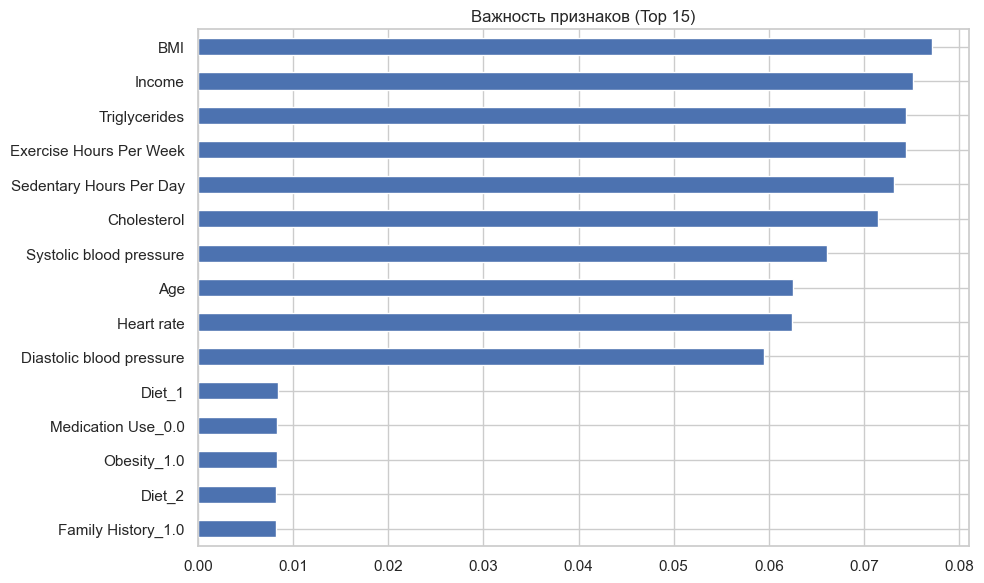

['randomforest_model.joblib']

In [27]:
# –ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –∏ —á–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
cat_features = [
    'Diabetes', 'Family History', 'Obesity', 
    'Alcohol Consumption', 'Diet', 'Previous Heart Problems',
    'Medication Use', 'Stress Level', 'Physical Activity Days Per Week',
    'Sleep Hours Per Day', 'Gender'
]

# –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è –∏ —É–¥–∞–ª–µ–Ω–∏–µ –Ω–µ–Ω—É–∂–Ω–æ–≥–æ
X = df_train.drop(['Heart Attack Risk (Binary)', 'id'], axis=1)
y = df_train['Heart Attack Risk (Binary)']

# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö –¥–æ –∫–æ–¥–∏—Ä–æ–≤–∞–Ω–∏—è
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞: OneHotEncoder –¥–ª—è –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ],
    remainder='passthrough'  # –æ—Å—Ç–∞–ª—å–Ω—ã–µ (—á–∏—Å–ª–æ–≤—ã–µ) –ø—Ä–æ–ø—É—Å—Ç–∏—Ç—å –±–µ–∑ –∏–∑–º–µ–Ω–µ–Ω–∏–π
)

# –ú–æ–¥–µ–ª—å –∏ –ø–∞–π–ø–ª–∞–π–Ω
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=2000,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced',
    ))
])

# –û–±—É—á–µ–Ω–∏–µ
try:
    model.fit(X_train, y_train)

    # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # –ú–µ—Ç—Ä–∏–∫–∏
    print("\n–ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–º –Ω–∞–±–æ—Ä–µ:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # –ü–æ–ª—É—á–µ–Ω–∏–µ –≤–∞–∂–Ω–æ—Å—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    rf_model = model.named_steps['classifier']
    ohe = model.named_steps['preprocessor'].named_transformers_['cat']
    ohe_feature_names = ohe.get_feature_names_out(cat_features)
    num_features = [col for col in X.columns if col not in cat_features]
    all_feature_names = np.concatenate([ohe_feature_names, num_features])

    importances = rf_model.feature_importances_
    feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

    print("\n–¢–æ–ø-15 –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:")
    print(feat_imp.head(15))

    # –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
    plt.figure(figsize=(10, 6))
    feat_imp.head(15).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title("–í–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (Top 15)")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"–ü—Ä–æ–∏–∑–æ—à–ª–∞ –æ—à–∏–±–∫–∞: {str(e)}")

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ
# dump(model, 'randomforest_model.joblib')

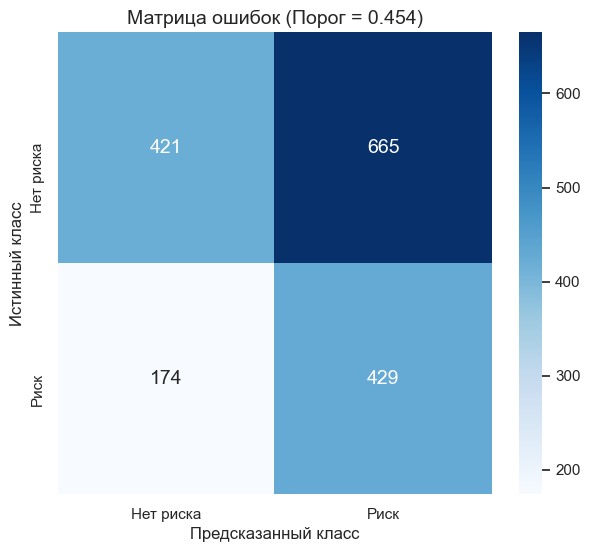


–û—Ü–µ–Ω–∫–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ (–ø–æ—Ä–æ–≥ = 0.454)

üìä –û—Å–Ω–æ–≤–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏:
Accuracy: 0.5033
Precision: 0.3921
Recall: 0.7114
F1-score: 0.5056
ROC-AUC: 0.5935

üîç –î–µ—Ç–∞–ª–∏–∑–∞—Ü–∏—è –æ—à–∏–±–æ–∫:
True Negatives (TN): 421 | –ü—Ä–∞–≤–∏–ª—å–Ω–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ '–ù–µ—Ç —Ä–∏—Å–∫–∞'
False Positives (FP): 665 | –õ–æ–∂–Ω—ã–µ —Ç—Ä–µ–≤–æ–≥–∏
False Negatives (FN): 174 | –ü—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ —Å–ª—É—á–∞–∏ —Ä–∏—Å–∫–∞
True Positives (TP): 429 | –ü—Ä–∞–≤–∏–ª—å–Ω–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ '–†–∏—Å–∫'

üìù –ü–æ–ª–Ω—ã–π –æ—Ç—á–µ—Ç:
              precision    recall  f1-score   support

   –ù–µ—Ç —Ä–∏—Å–∫–∞       0.71      0.39      0.50      1086
        –†–∏—Å–∫       0.39      0.71      0.51       603

    accuracy                           0.50      1689
   macro avg       0.55      0.55      0.50      1689
weighted avg       0.59      0.50      0.50      1689



In [28]:
# –ü–æ–ª—É—á–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏
y_proba = model.predict_proba(X_test)[:, 1]

evaluate_model_with_threshold(y_test, y_proba, 0.454)

## –ú–æ–¥–µ–ª—å CatBoost

In [ ]:
# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
X = df_train.drop(['Heart Attack Risk (Binary)', 'id'], axis=1)
y = df_train['Heart Attack Risk (Binary)']

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
cat_features = ['Diabetes', 'Family History', 'Obesity', 
               'Alcohol Consumption', 'Diet', 'Previous Heart Problems',
               'Medication Use', 'Stress Level', 'Physical Activity Days Per Week',
               'Sleep Hours Per Day', 'Gender']

# –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –≤ —Å—Ç—Ä–æ–∫–æ–≤—ã–π —Ç–∏–ø
for col in cat_features:
    X[col] = X[col].astype(str)

# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è CatBoost —Å –ø—Ä–∞–≤–∏–ª—å–Ω–æ–π —Ñ—É–Ω–∫—Ü–∏–µ–π –ø–æ—Ç–µ—Ä—å
catboost = CatBoostClassifier(
    random_seed=42,
    verbose=100,  # –ë—É–¥–µ–º –≤–∏–¥–µ—Ç—å –ø—Ä–æ–≥—Ä–µ—Å—Å –æ–±—É—á–µ–Ω–∏—è
    auto_class_weights='Balanced',
    loss_function='Logloss',  # –ü—Ä–∞–≤–∏–ª—å–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è –ø–æ—Ç–µ—Ä—å –¥–ª—è –±–∏–Ω–∞—Ä–Ω–æ–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏
    # eval_metric='F1',  # 'AUC', , 'Recall', 'Precision' 
    task_type='CPU',
    devices='0', 
    early_stopping_rounds=500,
    use_best_model=True,
)

# –ü–æ–¥–±–æ—Ä –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
try:
    catboost.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test))
    
    # –û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏
    y_pred = catboost.predict(X_test)
    y_pred_proba = catboost.predict_proba(X_test)[:, 1]
    
    print("\n–ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–º –Ω–∞–±–æ—Ä–µ:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    
    # –í–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    feature_importance = catboost.get_feature_importance(prettified=True)
    print("\n–í–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:")
    print(feature_importance)

    
except Exception as e:
    print(f"–ü—Ä–æ–∏–∑–æ—à–ª–∞ –æ—à–∏–±–∫–∞: {str(e)}")
    print("–ü–æ–ø—Ä–æ–±—É–π—Ç–µ —É–º–µ–Ω—å—à–∏—Ç—å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –∏–ª–∏ –∏–∑–º–µ–Ω–∏—Ç—å –∏—Ö –¥–∏–∞–ø–∞–∑–æ–Ω—ã")

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –≤ —Ñ–∞–π–ª .cbm (CatBoost Model)
# catboost.save_model('catboost_model.cbm')

Learning rate set to 0.050792
0:	learn: 0.6925270	test: 0.6930698	best: 0.6930698 (0)	total: 553ms	remaining: 9m 12s
100:	learn: 0.6628066	test: 0.6922142	best: 0.6922142 (100)	total: 21.4s	remaining: 3m 10s
200:	learn: 0.6271883	test: 0.6911367	best: 0.6909803 (192)	total: 33.2s	remaining: 2m 11s
300:	learn: 0.5744884	test: 0.6906764	best: 0.6896912 (241)	total: 42.7s	remaining: 1m 39s
400:	learn: 0.5334441	test: 0.6892839	best: 0.6892279 (391)	total: 54.4s	remaining: 1m 21s
500:	learn: 0.4948257	test: 0.6914593	best: 0.6890423 (418)	total: 1m 4s	remaining: 1m 3s
600:	learn: 0.4644174	test: 0.6940043	best: 0.6890423 (418)	total: 1m 12s	remaining: 48.1s
700:	learn: 0.4360608	test: 0.6974977	best: 0.6890423 (418)	total: 1m 21s	remaining: 34.6s
800:	learn: 0.4095324	test: 0.6999414	best: 0.6890423 (418)	total: 1m 30s	remaining: 22.5s
900:	learn: 0.3860391	test: 0.7018558	best: 0.6890423 (418)	total: 1m 43s	remaining: 11.4s
Stopped by overfitting detector  (500 iterations wait)

bestTest 

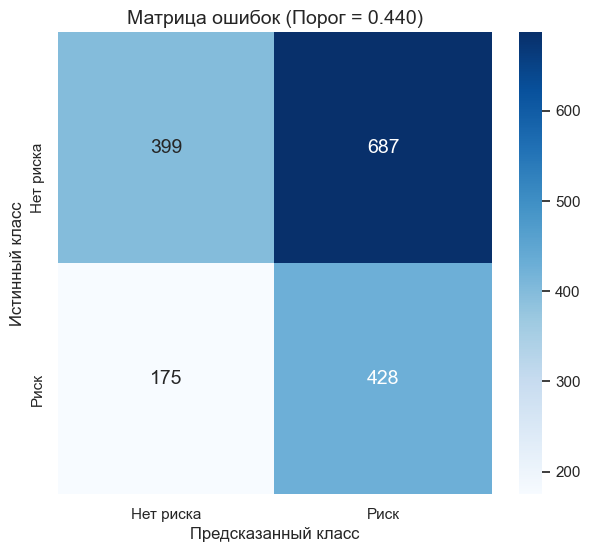


–û—Ü–µ–Ω–∫–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ (–ø–æ—Ä–æ–≥ = 0.440)

üìä –û—Å–Ω–æ–≤–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏:
Accuracy: 0.4896
Precision: 0.3839
Recall: 0.7098
F1-score: 0.4983
ROC-AUC: 0.5637

üîç –î–µ—Ç–∞–ª–∏–∑–∞—Ü–∏—è –æ—à–∏–±–æ–∫:
True Negatives (TN): 399 | –ü—Ä–∞–≤–∏–ª—å–Ω–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ '–ù–µ—Ç —Ä–∏—Å–∫–∞'
False Positives (FP): 687 | –õ–æ–∂–Ω—ã–µ —Ç—Ä–µ–≤–æ–≥–∏
False Negatives (FN): 175 | –ü—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ —Å–ª—É—á–∞–∏ —Ä–∏—Å–∫–∞
True Positives (TP): 428 | –ü—Ä–∞–≤–∏–ª—å–Ω–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ '–†–∏—Å–∫'

üìù –ü–æ–ª–Ω—ã–π –æ—Ç—á–µ—Ç:
              precision    recall  f1-score   support

   –ù–µ—Ç —Ä–∏—Å–∫–∞       0.70      0.37      0.48      1086
        –†–∏—Å–∫       0.38      0.71      0.50       603

    accuracy                           0.49      1689
   macro avg       0.54      0.54      0.49      1689
weighted avg       0.58      0.49      0.49      1689



In [30]:
# –ü–æ–ª—É—á–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏
y_proba = catboost.predict_proba(X_test)[:, 1]

evaluate_model_with_threshold(y_test, y_proba, 0.44)

## –û–ø–∏—Å–∞–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –º–æ–¥–µ–ª–µ–π
–í —Ä–∞–º–∫–∞—Ö –ø—Ä–æ–µ–∫—Ç–∞ –±—ã–ª–∏ –æ–±—É—á–µ–Ω—ã –∏ –ø—Ä–æ—Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω—ã —Ä–∞–∑–ª–∏—á–Ω—ã–µ –º–æ–¥–µ–ª–∏ –º–∞—à–∏–Ω–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è –¥–ª—è –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏—è —Ä–∏—Å–∫–∞ —Å–µ—Ä–¥–µ—á–Ω–æ–≥–æ –ø—Ä–∏—Å—Ç—É–ø–∞:

#### Random Forest Classifier (–ø–æ—Ä–æ–≥ = 0.454)

**–î–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å –ø–æ–∫–∞–∑–∞–ª–∞ —Å–ª–µ–¥—É—é—â–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã:**

- Accuracy: 0.5033 ‚Äî –æ–±—â–∞—è —Ç–æ—á–Ω–æ—Å—Ç—å –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Å–æ—Å—Ç–∞–≤–ª—è–µ—Ç –æ–∫–æ–ª–æ 50%
- Precision: 0.3921 ‚Äî –∏–∑ –≤—Å–µ—Ö –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö —Å–ª—É—á–∞–µ–≤ —Ä–∏—Å–∫–∞ —Ç–æ–ª—å–∫–æ 39% –¥–µ–π—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ –∏–º–µ–ª–∏ –≤—ã—Å–æ–∫–∏–π —Ä–∏—Å–∫
- Recall: 0.7114 ‚Äî –º–æ–¥–µ–ª—å –≤—ã—è–≤–ª—è–µ—Ç 71% –≤—Å–µ—Ö —Ä–µ–∞–ª—å–Ω—ã—Ö —Å–ª—É—á–∞–µ–≤ –≤—ã—Å–æ–∫–æ–≥–æ —Ä–∏—Å–∫–∞
- F1-score: 0.5056 ‚Äî –≥–∞—Ä–º–æ–Ω–∏—á–µ—Å–∫–æ–µ —Å—Ä–µ–¥–Ω–µ–µ –º–µ–∂–¥—É precision –∏ recall
- ROC-AUC: 0.5935 ‚Äî —Å–ø–æ—Å–æ–±–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ —Ä–∞–∑–ª–∏—á–∞—Ç—å –∫–ª–∞—Å—Å—ã –≤—ã—à–µ —Å–ª—É—á–∞–π–Ω–æ–≥–æ —É—Ä–æ–≤–Ω—è

**–î–µ—Ç–∞–ª–∏–∑–∞—Ü–∏—è –æ—à–∏–±–æ–∫:**

- True Negatives (TN): 421 ‚Äî –ø—Ä–∞–≤–∏–ª—å–Ω–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ —Å–ª—É—á–∞–∏ –±–µ–∑ —Ä–∏—Å–∫–∞
- False Positives (FP): 665 ‚Äî –ª–æ–∂–Ω—ã–µ —Ç—Ä–µ–≤–æ–≥–∏ (–ø–∞—Ü–∏–µ–Ω—Ç—ã –±–µ–∑ —Ä–∏—Å–∫–∞, –∫–æ—Ç–æ—Ä—ã–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω —Ä–∏—Å–∫)
- False Negatives (FN): 174 ‚Äî –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ —Å–ª—É—á–∞–∏ —Ä–∏—Å–∫–∞
- True Positives (TP): 429 ‚Äî –ø—Ä–∞–≤–∏–ª—å–Ω–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ —Å–ª—É—á–∞–∏ —Å —Ä–∏—Å–∫–æ–º

#### CatBoost Classifier (–ø–æ—Ä–æ–≥ = 0.440)

**–†–µ–∑—É–ª—å—Ç–∞—Ç—ã –º–æ–¥–µ–ª–∏ CatBoost:**

- Accuracy: 0.4896 ‚Äî –æ–±—â–∞—è —Ç–æ—á–Ω–æ—Å—Ç—å –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –æ–∫–æ–ª–æ 49%
- Precision: 0.3839 ‚Äî —Ç–æ—á–Ω–æ—Å—Ç—å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è —Ä–∏—Å–∫–∞ 38%
- Recall: 0.7098 ‚Äî –ø–æ–ª–Ω–æ—Ç–∞ –≤—ã—è–≤–ª–µ–Ω–∏—è —Ä–∏—Å–∫–∞ 71%
- F1-score: 0.4983 ‚Äî –≥–∞—Ä–º–æ–Ω–∏—á–µ—Å–∫–æ–µ —Å—Ä–µ–¥–Ω–µ–µ
- ROC-AUC: 0.5637 ‚Äî —Å–ø–æ—Å–æ–±–Ω–æ—Å—Ç—å —Ä–∞–∑–ª–∏—á–∞—Ç—å –∫–ª–∞—Å—Å—ã

**–î–µ—Ç–∞–ª–∏–∑–∞—Ü–∏—è –æ—à–∏–±–æ–∫:**

- True Negatives (TN): 399
- False Positives (FP): 687
- False Negatives (FN): 175
- True Positives (TP): 428

### –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π
- Random Forest –ø–æ–∫–∞–∑–∞–ª –Ω–µ–º–Ω–æ–≥–æ –ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –ø–æ –≤—Å–µ–º –º–µ—Ç—Ä–∏–∫–∞–º
- –û–±–µ –º–æ–¥–µ–ª–∏ –∏–º–µ—é—Ç —Å—Ö–æ–∂–∏–π —É—Ä–æ–≤–µ–Ω—å Recall (~71%), —á—Ç–æ —è–≤–ª—è–µ—Ç—Å—è –∫–ª—é—á–µ–≤—ã–º –ø–æ–∫–∞–∑–∞—Ç–µ–ª–µ–º –¥–ª—è –¥–∞–Ω–Ω–æ–π –∑–∞–¥–∞—á–∏
- Random Forest –±—ã–ª –≤—ã–±—Ä–∞–Ω –∫–∞–∫ –æ—Å–Ω–æ–≤–Ω–æ–π –∞–ª–≥–æ—Ä–∏—Ç–º –∑–∞ —Å—á—ë—Ç –±–æ–ª–µ–µ –≤—ã—Å–æ–∫–æ–π —Ç–æ—á–Ω–æ—Å—Ç–∏ –∏ –ø—Ä–æ—Å—Ç–æ—Ç—ã –∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ü–∏–∏

### –í–∞–∂–Ω—ã–µ –æ—Å–æ–±–µ–Ω–Ω–æ—Å—Ç–∏ –∑–∞–¥–∞—á–∏
**–í –º–µ–¥–∏—Ü–∏–Ω—Å–∫–æ–π –∑–∞–¥–∞—á–µ –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏—è —Ä–∏—Å–∫–∞ —Å–µ—Ä–¥–µ—á–Ω–æ–≥–æ –ø—Ä–∏—Å—Ç—É–ø–∞ –∫—Ä–∏—Ç–∏—á–µ—Å–∫–∏ –≤–∞–∂–Ω–æ –º–∞–∫—Å–∏–º–∏–∑–∏—Ä–æ–≤–∞—Ç—å Recall (–ø–æ–ª–Ω–æ—Ç—É –≤—ã—è–≤–ª–µ–Ω–∏—è), —Ç–∞–∫ –∫–∞–∫ –ø—Ä–æ–ø—É—Å–∫ –ø–∞—Ü–∏–µ–Ω—Ç–∞ —Å –≤—ã—Å–æ–∫–∏–º —Ä–∏—Å–∫–æ–º –º–æ–∂–µ—Ç –∏–º–µ—Ç—å —Å–µ—Ä—å—ë–∑–Ω—ã–µ –ø–æ—Å–ª–µ–¥—Å—Ç–≤–∏—è –¥–ª—è –∑–¥–æ—Ä–æ–≤—å—è. –ü–æ—ç—Ç–æ–º—É –æ–±–µ –º–æ–¥–µ–ª–∏ –Ω–∞—Å—Ç—Ä–æ–µ–Ω—ã –Ω–∞ –ø—Ä–∏–æ—Ä–∏—Ç–µ—Ç –≤—ã—è–≤–ª–µ–Ω–∏—è –≤—Å–µ—Ö –≤–æ–∑–º–æ–∂–Ω—ã—Ö —Å–ª—É—á–∞–µ–≤ —Ä–∏—Å–∫–∞, –¥–∞–∂–µ —Ü–µ–Ω–æ–π —É–≤–µ–ª–∏—á–µ–Ω–∏—è –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –ª–æ–∂–Ω—ã—Ö —Ç—Ä–µ–≤–æ–≥.**

# –ì–ª–∞–≤–Ω—ã–π –≤—ã–≤–æ–¥ –ø–æ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º –ø—Ä–æ–µ–∫—Ç–∞

–í —Ä–µ–∑—É–ª—å—Ç–∞—Ç–µ –ø—Ä–æ–¥–µ–ª–∞–Ω–Ω–æ–π —Ä–∞–±–æ—Ç—ã –±—ã–ª —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω –ø–æ–ª–Ω—ã–π —Ü–∏–∫–ª –∞–Ω–∞–ª–∏–∑–∞ –∏ –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è —Å–µ—Ä–≤–∏—Å–∞ –¥–ª—è –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏—è —Ä–∏—Å–∫–∞ —Å–µ—Ä–¥–µ—á–Ω–æ–≥–æ –ø—Ä–∏—Å—Ç—É–ø–∞:
- –ü—Ä–æ–≤–µ–¥—ë–Ω —Ç—â–∞—Ç–µ–ª—å–Ω—ã–π –∏—Å—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑ –¥–∞–Ω–Ω—ã—Ö (EDA), –≤—ã—è–≤–ª–µ–Ω—ã –∫–ª—é—á–µ–≤—ã–µ —Ñ–∞–∫—Ç–æ—Ä—ã —Ä–∏—Å–∫–∞ –∏ –æ—Å–æ–±–µ–Ω–Ω–æ—Å—Ç–∏ –¥–∞—Ç–∞—Å–µ—Ç–∞.
- –í—ã–ø–æ–ª–Ω–µ–Ω–∞ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–∞—è –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö: –æ–±—Ä–∞–±–æ—Ç–∞–Ω—ã –ø—Ä–æ–ø—É—Å–∫–∏, –≤—ã–±—Ä–æ—Å—ã, –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω—ã –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏.
- –û–±—É—á–µ–Ω—ã –∏ –ø—Ä–æ—Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω—ã —Å–æ–≤—Ä–µ–º–µ–Ω–Ω—ã–µ –º–æ–¥–µ–ª–∏ –º–∞—à–∏–Ω–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è. Random Forest –ø–æ–∫–∞–∑–∞–ª –ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã —Å Recall 71%, —á—Ç–æ –∫—Ä–∏—Ç–∏—á–µ—Å–∫–∏ –≤–∞–∂–Ω–æ –¥–ª—è –º–µ–¥–∏—Ü–∏–Ω—Å–∫–æ–π –∑–∞–¥–∞—á–∏.
- –†–∞–∑—Ä–∞–±–æ—Ç–∞–Ω–æ —É–¥–æ–±–Ω–æ–µ –≤–µ–±-–ø—Ä–∏–ª–æ–∂–µ–Ω–∏–µ –Ω–∞ FastAPI —Å –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç—å—é –∑–∞–≥—Ä—É–∂–∞—Ç—å –¥–∞–Ω–Ω—ã–µ –∏ –ø–æ–ª—É—á–∞—Ç—å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∫–∞–∫ –¥–ª—è –æ–¥–Ω–æ–≥–æ –ø–∞—Ü–∏–µ–Ω—Ç–∞, —Ç–∞–∫ –∏ –¥–ª—è –≥—Ä—É–ø–ø—ã –ø–∞—Ü–∏–µ–Ω—Ç–æ–≤ (—á–µ—Ä–µ–∑ CSV).
- –†–µ–∞–ª–∏–∑–æ–≤–∞–Ω –∏–Ω—Ç—É–∏—Ç–∏–≤–Ω–æ –ø–æ–Ω—è—Ç–Ω—ã–π –∏–Ω—Ç–µ—Ä—Ñ–µ–π—Å –∏ –ø–æ–¥—Ä–æ–±–Ω–∞—è –¥–æ–∫—É–º–µ–Ω—Ç–∞—Ü–∏—è –¥–ª—è –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è.
- –ü—Ä–æ–µ–∫—Ç –æ—Ñ–æ—Ä–º–ª–µ–Ω –≤ –≤–∏–¥–µ —Ä–µ–ø–æ–∑–∏—Ç–æ—Ä–∏—è, —á—Ç–æ –æ–±–µ—Å–ø–µ—á–∏–≤–∞–µ—Ç –µ–≥–æ –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º–æ—Å—Ç—å –∏ —É–¥–æ–±—Å—Ç–≤–æ –ø–µ—Ä–µ–¥–∞—á–∏ –¥—Ä—É–≥–∏–º –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è–º.

**–ò—Ç–æ–≥:**

–°–æ–∑–¥–∞–Ω–Ω—ã–π —Å–µ—Ä–≤–∏—Å –ø–æ–∑–≤–æ–ª—è–µ—Ç –±—ã—Å—Ç—Ä–æ –∏ —É–¥–æ–±–Ω–æ –æ—Ü–µ–Ω–∏–≤–∞—Ç—å —Ä–∏—Å–∫ —Å–µ—Ä–¥–µ—á–Ω–æ–≥–æ –ø—Ä–∏—Å—Ç—É–ø–∞ –Ω–∞ –æ—Å–Ω–æ–≤–µ –∞–∫—Ç—É–∞–ª—å–Ω—ã—Ö –º–µ–¥–∏—Ü–∏–Ω—Å–∫–∏—Ö –¥–∞–Ω–Ω—ã—Ö. –ú–æ–¥–µ–ª—å –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∞ –Ω–∞ –º–∞–∫—Å–∏–º–∏–∑–∞—Ü–∏—é Recall (71%), —á—Ç–æ –æ–±–µ—Å–ø–µ—á–∏–≤–∞–µ—Ç –≤—ã—è–≤–ª–µ–Ω–∏–µ –±–æ–ª—å—à–∏–Ω—Å—Ç–≤–∞ —Å–ª—É—á–∞–µ–≤ –≤—ã—Å–æ–∫–æ–≥–æ —Ä–∏—Å–∫–∞, —á—Ç–æ –∫—Ä–∏—Ç–∏—á–µ—Å–∫–∏ –≤–∞–∂–Ω–æ –≤ –º–µ–¥–∏—Ü–∏–Ω—Å–∫–æ–π –ø—Ä–∞–∫—Ç–∏–∫–µ. –†–µ—à–µ–Ω–∏–µ –º–æ–∂–µ—Ç –±—ã—Ç—å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–æ –∫–∞–∫ –≤—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω—ã–π –∏–Ω—Å—Ç—Ä—É–º–µ–Ω—Ç –¥–ª—è –≤—Ä–∞—á–µ–π –∏ –ø–∞—Ü–∏–µ–Ω—Ç–æ–≤, –∞ —Ç–∞–∫–∂–µ –∫–∞–∫ –æ—Å–Ω–æ–≤–∞ –¥–ª—è –¥–∞–ª—å–Ω–µ–π—à–∏—Ö –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–π –∏ –≤–Ω–µ–¥—Ä–µ–Ω–∏—è –≤ –º–µ–¥–∏—Ü–∏–Ω—Å–∫—É—é –ø—Ä–∞–∫—Ç–∏–∫—É.